### Benchmarking based on PXD002099

#### The data set of Pursiheimo et al. consists of 48 UPS1 proteins spiked into a yeast proteome degest in five different concentrations: 2, 4, 10, 25 and 50 fmol/ul. An LTQ Orbitrap Velos MS was used to analyze three technical replicates of each concentrations. 

#### A fasta database of the yeast protein sequences merged with the spiked-in proteins sequence use used for searching. A false discoving rate of 0.01 was set as a threshold for peptide identifications and protein-level identifications

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/PXD002099/'
setwd(data_folder)

### Number of protein quantified

#### quantms quantified more proteins than DOI: 10.1093/bib/bbx054 and original result from DOI: 10.1021/acs.jproteome.5b00183. And most of proteins given in original paper is in our result 

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()

1892


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=10 fmol,1,1,5461842.0,110616_yeast_ups_10fmol.mzML
1,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,4,3025948.0,110618_yeast_ups_25fmol_r1.mzML
2,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,5,3061254.0,110618_yeast_ups_25fmol_r2.mzML
3,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=25 fmol,2,6,4087644.0,110618_yeast_ups_25fmol_r3.mzML
4,sp|P09938|RIR2_YEAST,AAADALSDLEIK,2,NaN,0,L,CT=Mixture;CN=UPS1;QY=50 fmol,3,7,2912077.0,110618_yeast_ups_50fmol_r1.mzML


#### overlap of quantified proteins

47


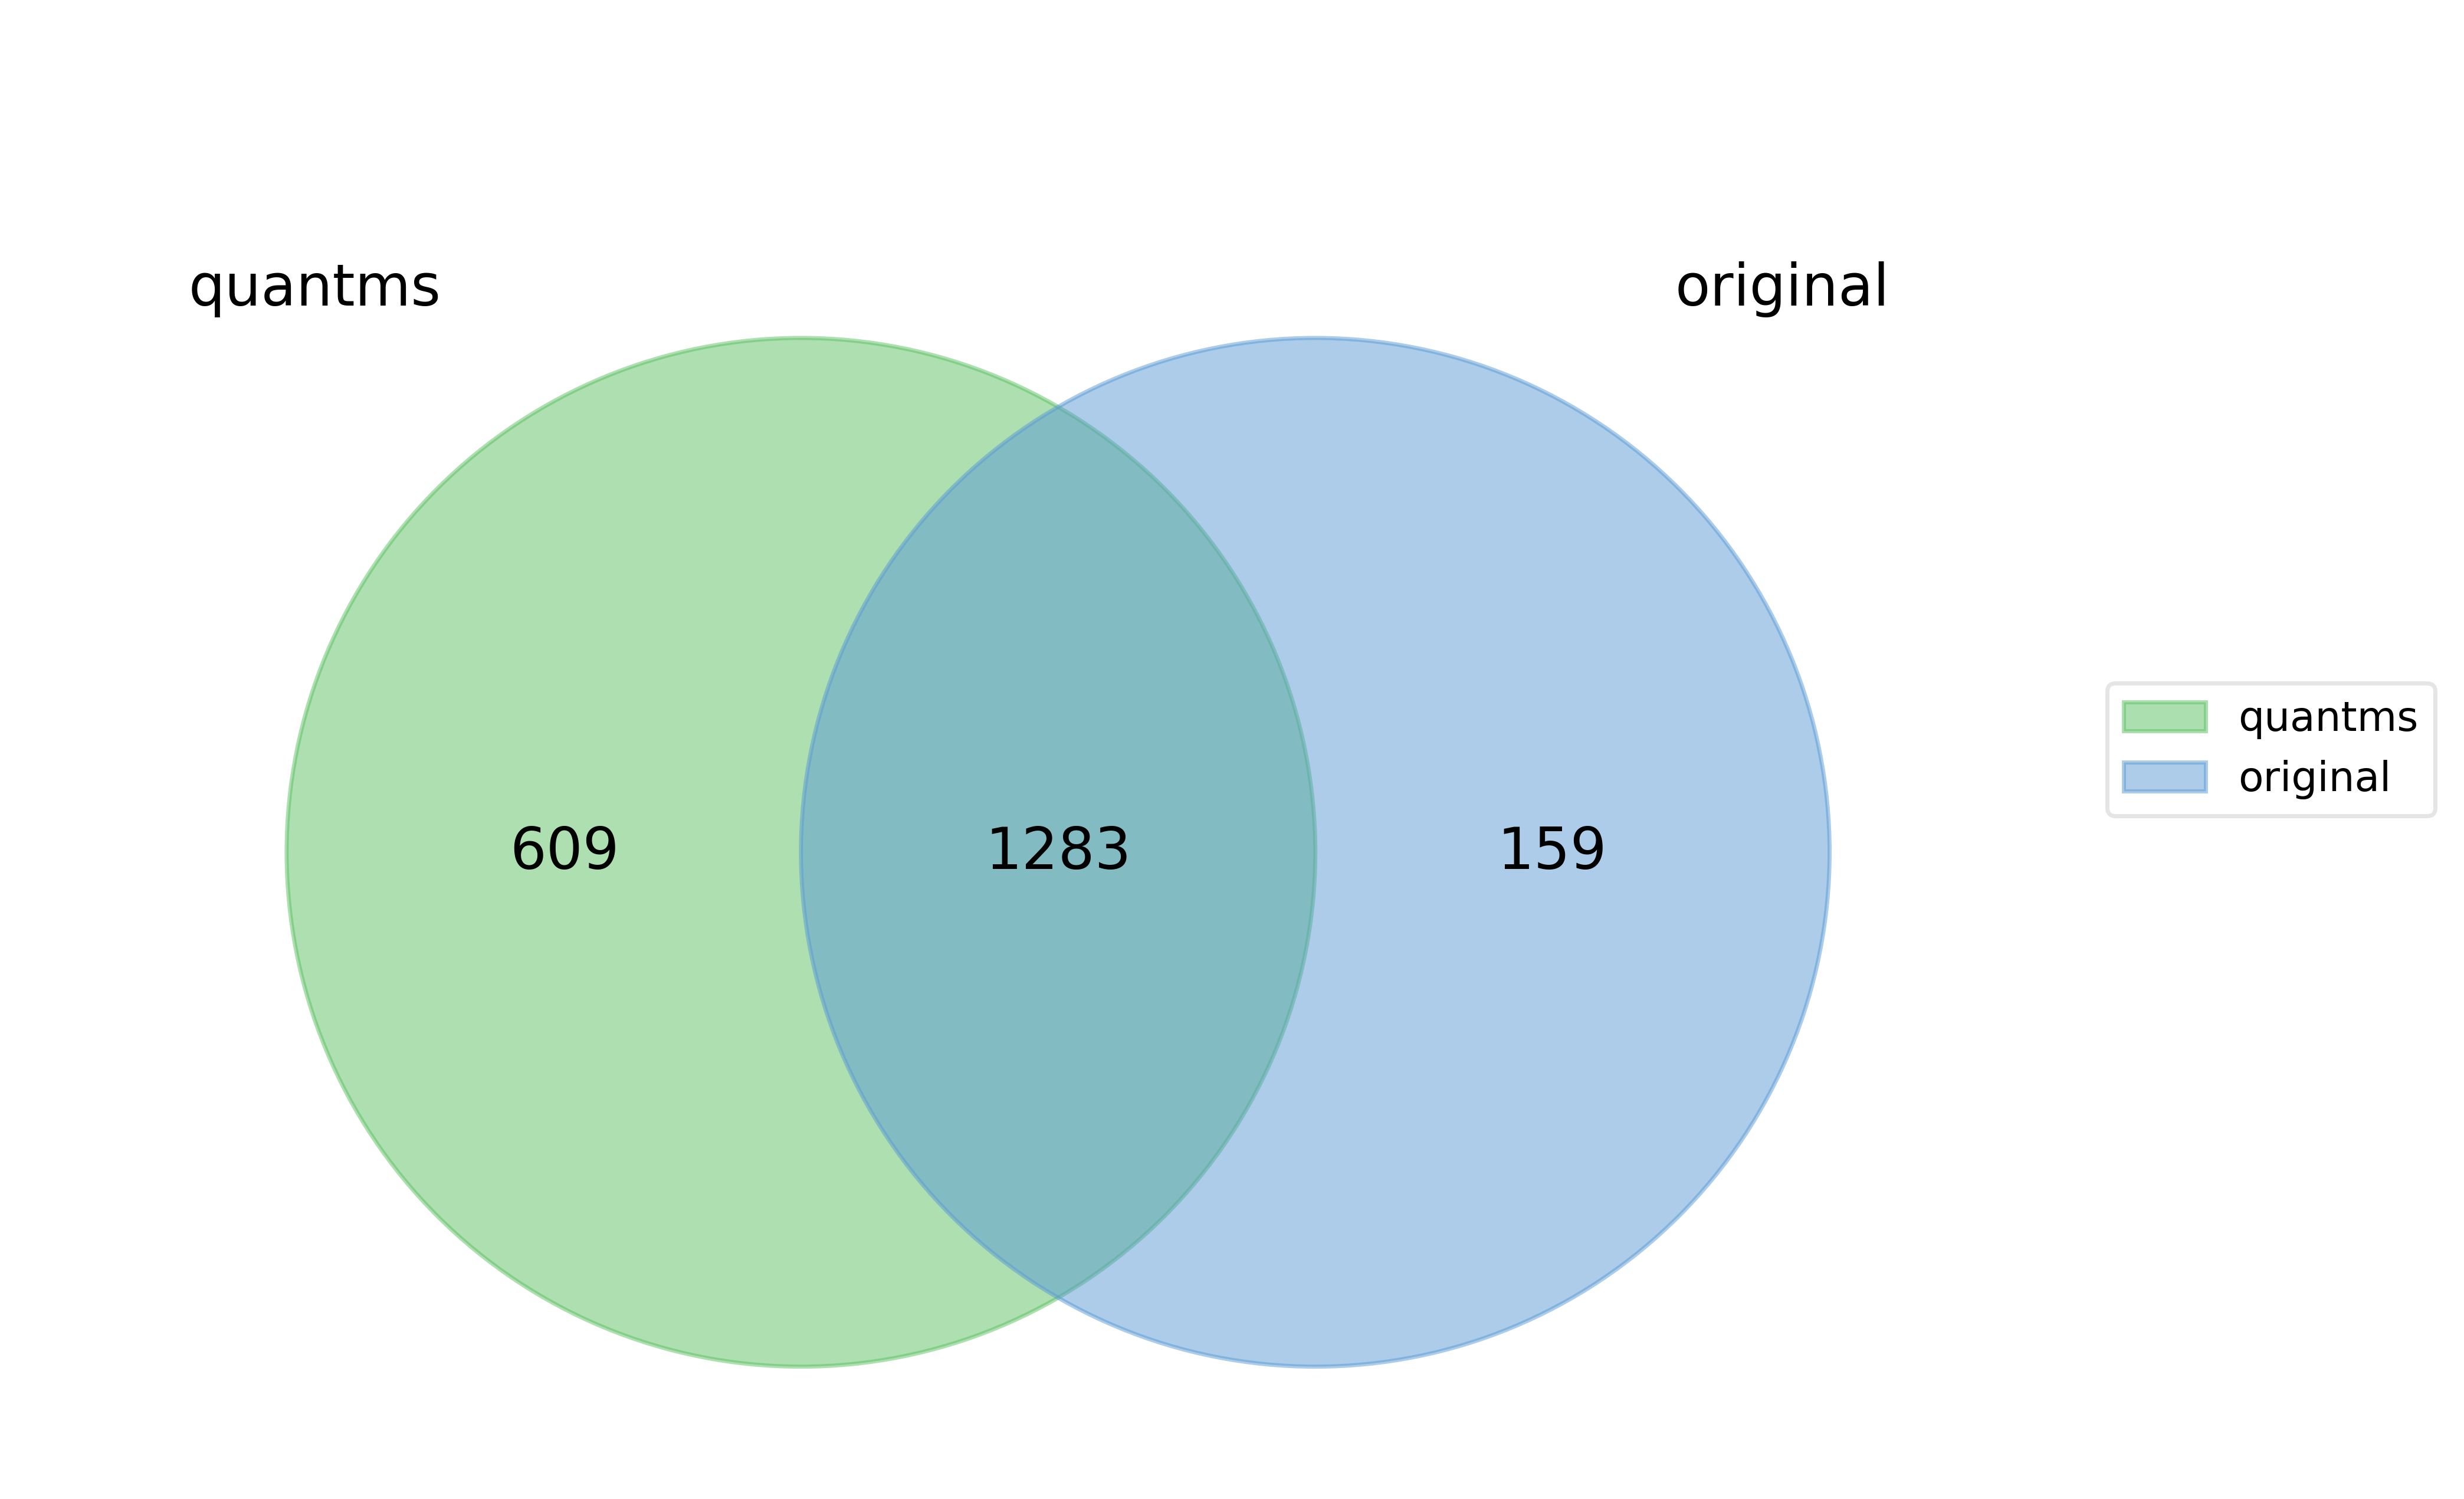

In [9]:
from pyvenn import venn
quantms['P1'] = quantms.apply(lambda x: ";".join(x['ProteinName'].split("|")[1::2]), axis=1)

original = pd.read_csv('YEAST-Data-NonNormalized.csv', sep=";", header=0)
print(len(set(original[original['Accession'].str.contains("ups")]['Accession'])))
labels = venn.get_labels([set(quantms['P1']), set(original['Accession'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=500)
plt.show()

### The total number of spiked-in proteins detected is 48 (48). All spiked-in proteins are quantified. It's better than other results :DOI: 10.1021/acs.jproteome.5b00183 (47 ups). and DOI: 10.1021/acs.jproteome.5b00183. (47 ups).

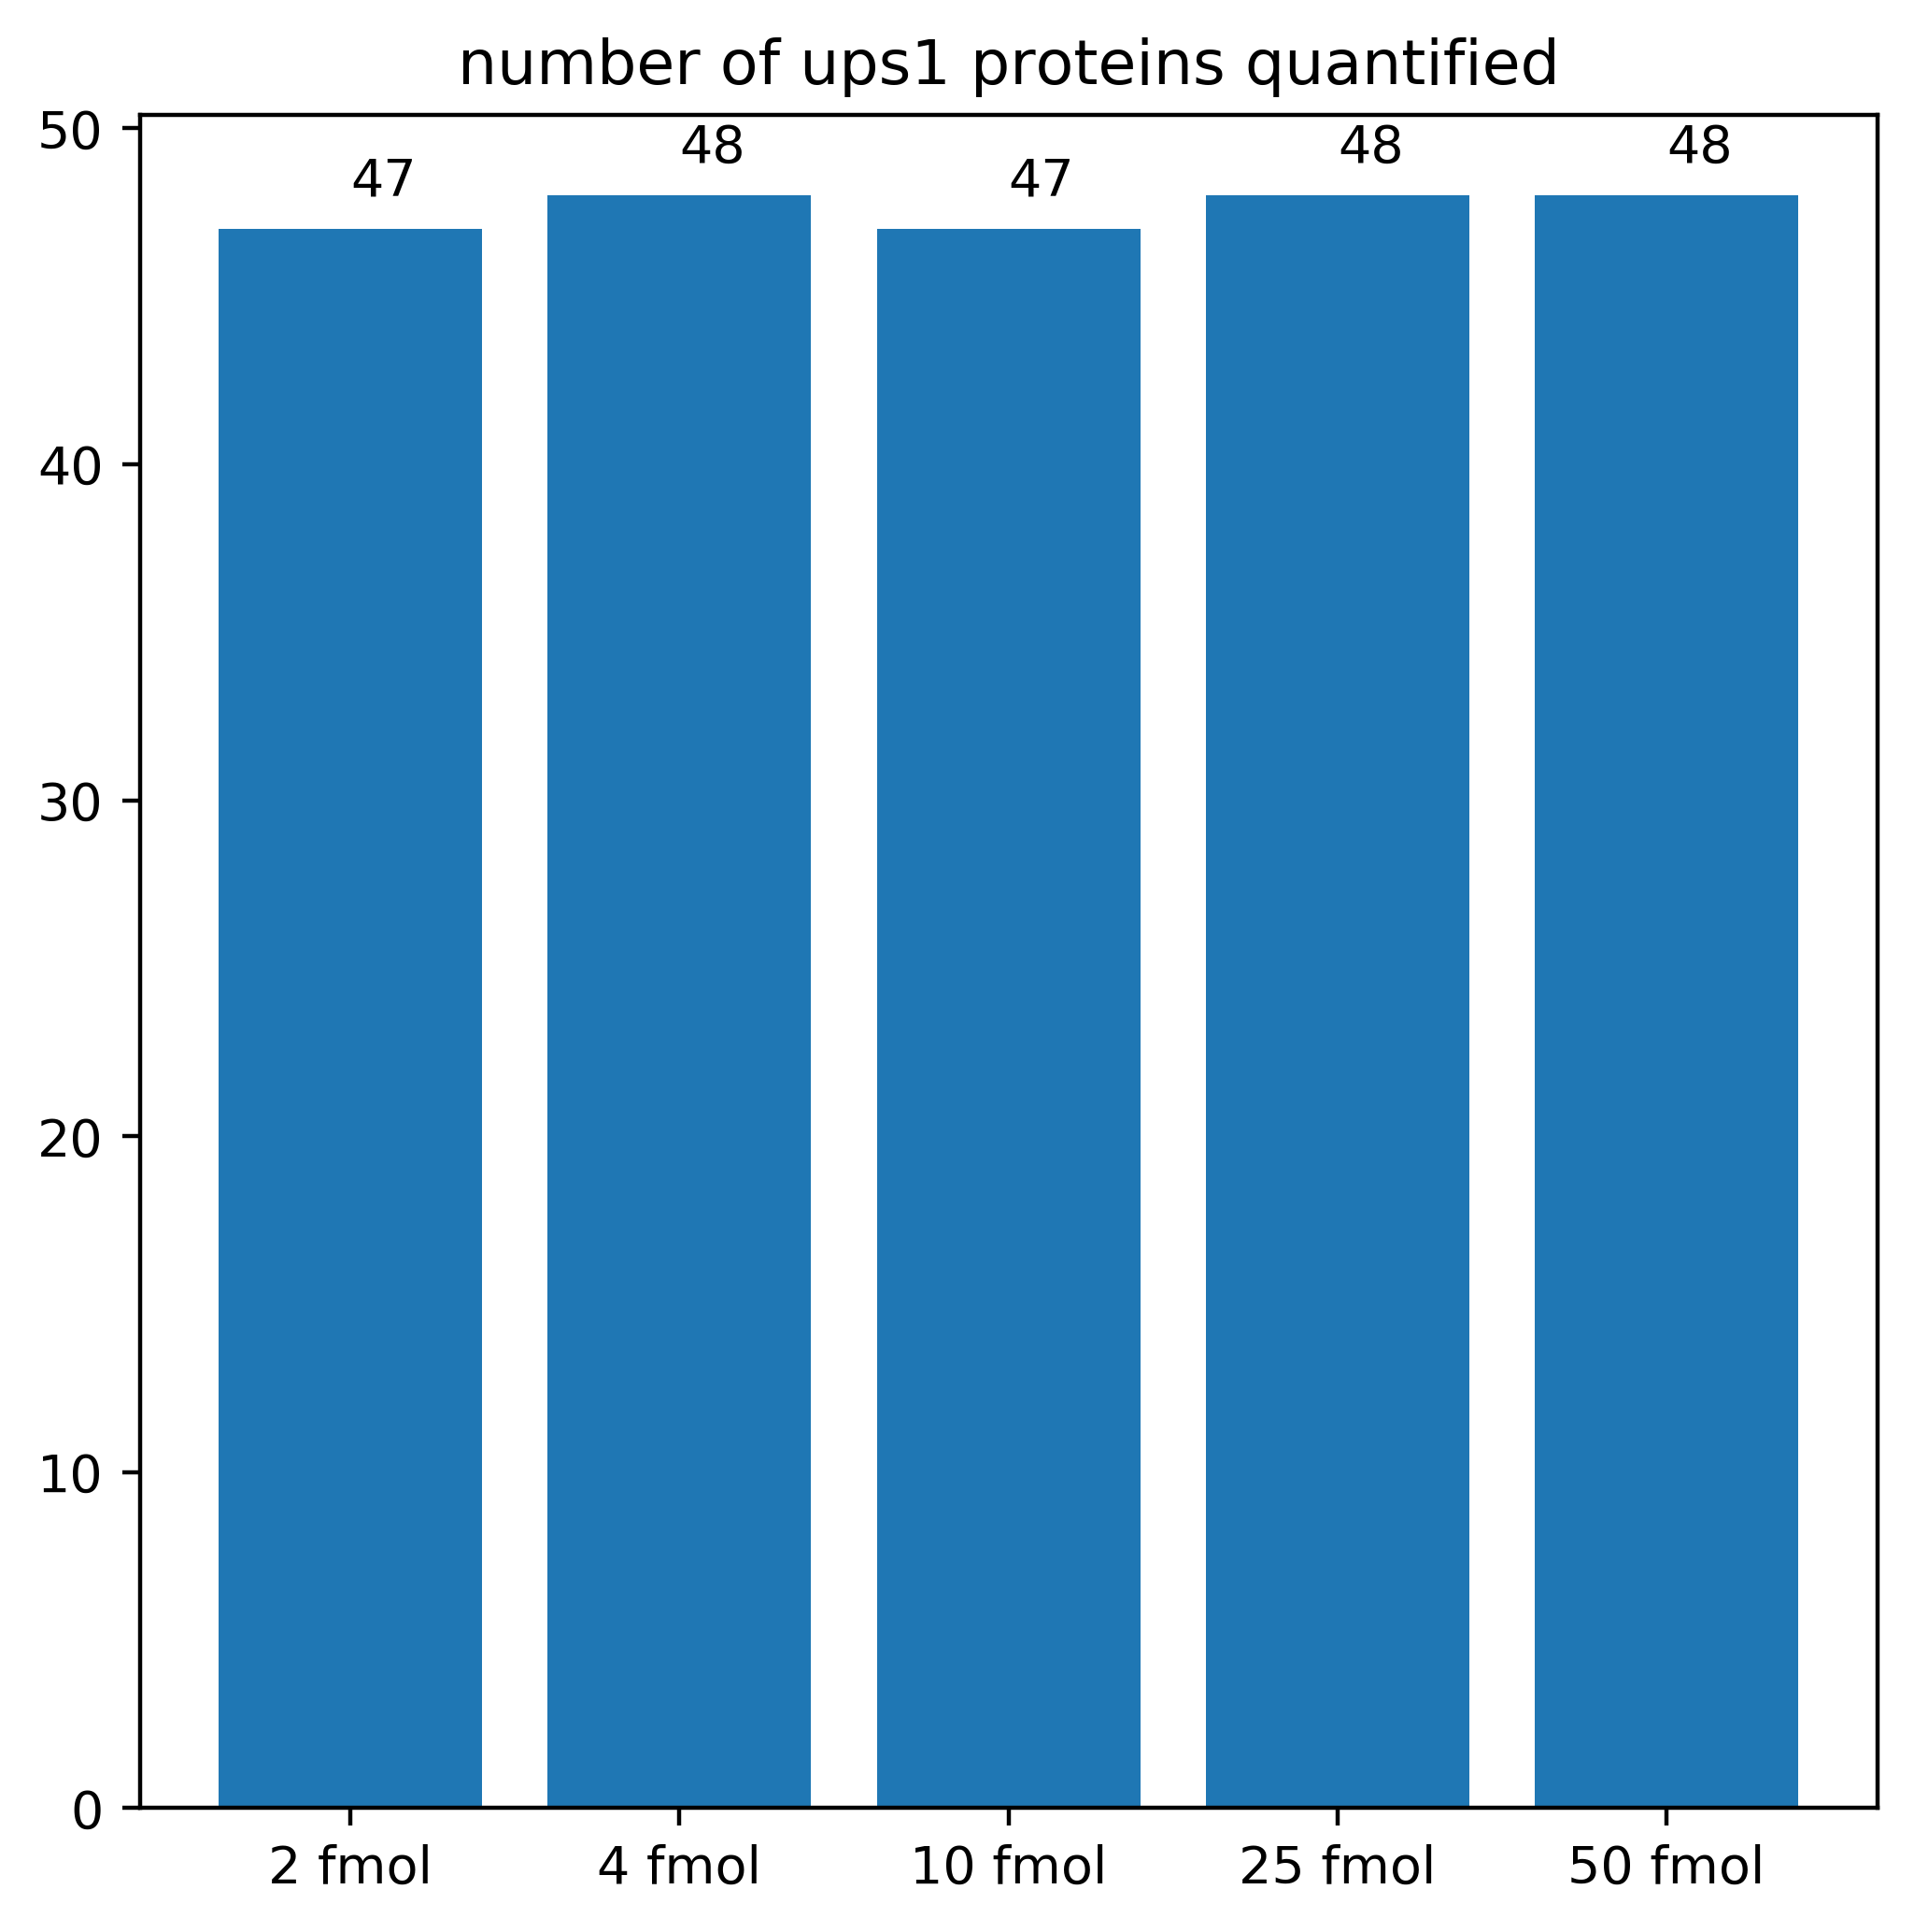

In [10]:
number_of_ups1 = dict()
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition.replace("CT=Mixture;CN=UPS1;QY=", "")] = len((set(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(6,6), dpi=400)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: int(item[0].replace("fmol",""))):
    num.append(value)
    label.append(key)
for x, y in zip(range(5), num):
    plt.text(x, y+1, y)

plt.bar(range(5), num)
plt.title("number of ups1 proteins quantified")
plt.xticks(range(5),label)
plt.show()

### Assess missing value

#### A common and pervasive problem in MS data are missing values. When using peptide peaking intensities for relative quantification, missing values are intensity values that are not recorded for a peptide in a sample/replicates. Missing values can occur because of multiple reasons and are mainly divided into two main categories : abundance-depdendent missing values (eg. the concentration of the peptide is below the detection limit of the instrument) or values missing completely at random (eg. the identification of the peptide is incorrect)

#### Proportion of missing values in the detected spiked-in proteins is 0.9% . It's very low

In [5]:
missing_values_ups = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        total += 3
        if len(msruns) < 3:
            missing_values_ups += (3 - len(msruns))
            
print(missing_values_ups / total)


0.00980392156862745


#### Proportion of missing value in background proteins is 12.7%,  It is better than other software or workflow like maxquant(14.5%)、Proteios(19.0%)、PEAKS(16.4%)、OpenMS(29.8%)

In [6]:
missing_values_background = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(-quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        total += 3
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        if len(msruns) < 3:
            missing_values_background += (3 - len(msruns))
            
print(missing_values_background / total)

0.1272383652256083


### Reproducibility between Analytical Replicate before msstats process

#### Proteomics analysis has many possiable sources of variability, although these variations impacts the identification of peptides and for replicates, proteomic identifications are far from completely random.

#### Testing each concentration in triplicate allowed us to calculate a coefficient of variation (CV) of peptide/protein intensities to asses signal extraction reproducibility annd workflow consistency, those are very important for proteomics analysis!

#### Calculate the metrics before msstats process to assess quantms. Of course is it necessary to calculate this metric after msstats processing?. Ignoring missing proteins at the same time. Missing values will be considered seperately.

#### CV = protein mean intensity within replicates / corresponding std. For the peptide intensity, abundances are summed over all charge states. Protein abundance will be computed from peptide abundances based on median. is it right ????.CV is calculated separately in background proteins and UPS1 proteins.

In [10]:
original.head()

,Accession,Peptide count,Peptides used for quantitation,110714_yeast_ups1_2fmol_r1,110714_yeast_ups1_2fmol_r2,110714_yeast_ups1_2fmol_r3,110714_yeast_ups1_4fmol_r2,110714_yeast_ups1_4fmol_r3,110714_yeast_ups1_4fmol_r4,110616_yeast_ups_10fmol,110616_yeast_ups_10fmol_r2,110616_yeast_ups_10fmol_r3,110618_yeast_ups_25fmol_r1,110618_yeast_ups_25fmol_r2,110618_yeast_ups_25fmol_r3,110618_yeast_ups_50fmol_r1,110618_yeast_ups_50fmol_r2,110618_yeast_ups_50fmol_r3
0,P02768ups,71,65,"1631970,358","1564213,628","1225776,722","2280319,85","2020222,34","3500138,203","3931687,747","2715316,12","2249414,364","7672800,553","5715744,16","8007694,012","14170408,05","8450106,295","9323650,28"
1,P02787ups,69,61,"2212574,687","1860224,784","1623286,438","2958176,709","2438424,284","4082824,31","4664071,349","3025729,509","2663232,916","9398466,233","7563425,538","10587661,76","16409074,33","9476020,194","10354434,48"
2,P02788ups,68,61,"2750775,563","2327828,503","1981513,557","3689056,444","3304724,447","5146522,07","6962234,972","4855991,396","3007193,587","15084092,31","13015247,1","17795589,84","27842623,5","16434125,44","18139139,15"
3,P10636-8ups,57,52,"1764390,281","1458767,213","1268176,144","2314466,983","1843820,377","3605064,315","3497281,208","2653392,897","2226529,647","8366197,524","6617033,636","8670428,657","14494030,52","8661951,474","9503136,001"
4,P19097,59,52,"3289352,492","2915790,255","2521383,32","3542545,75","4043925,089","3172731,052","1899339,277","1296596,117","974854,714","1352316,755","1121882,121","1584858,209","1692938,855","1185996,595","1529259,827"


#### At high concentrations, quantms has a smaller cv. CV looks very weird in 4 fmol

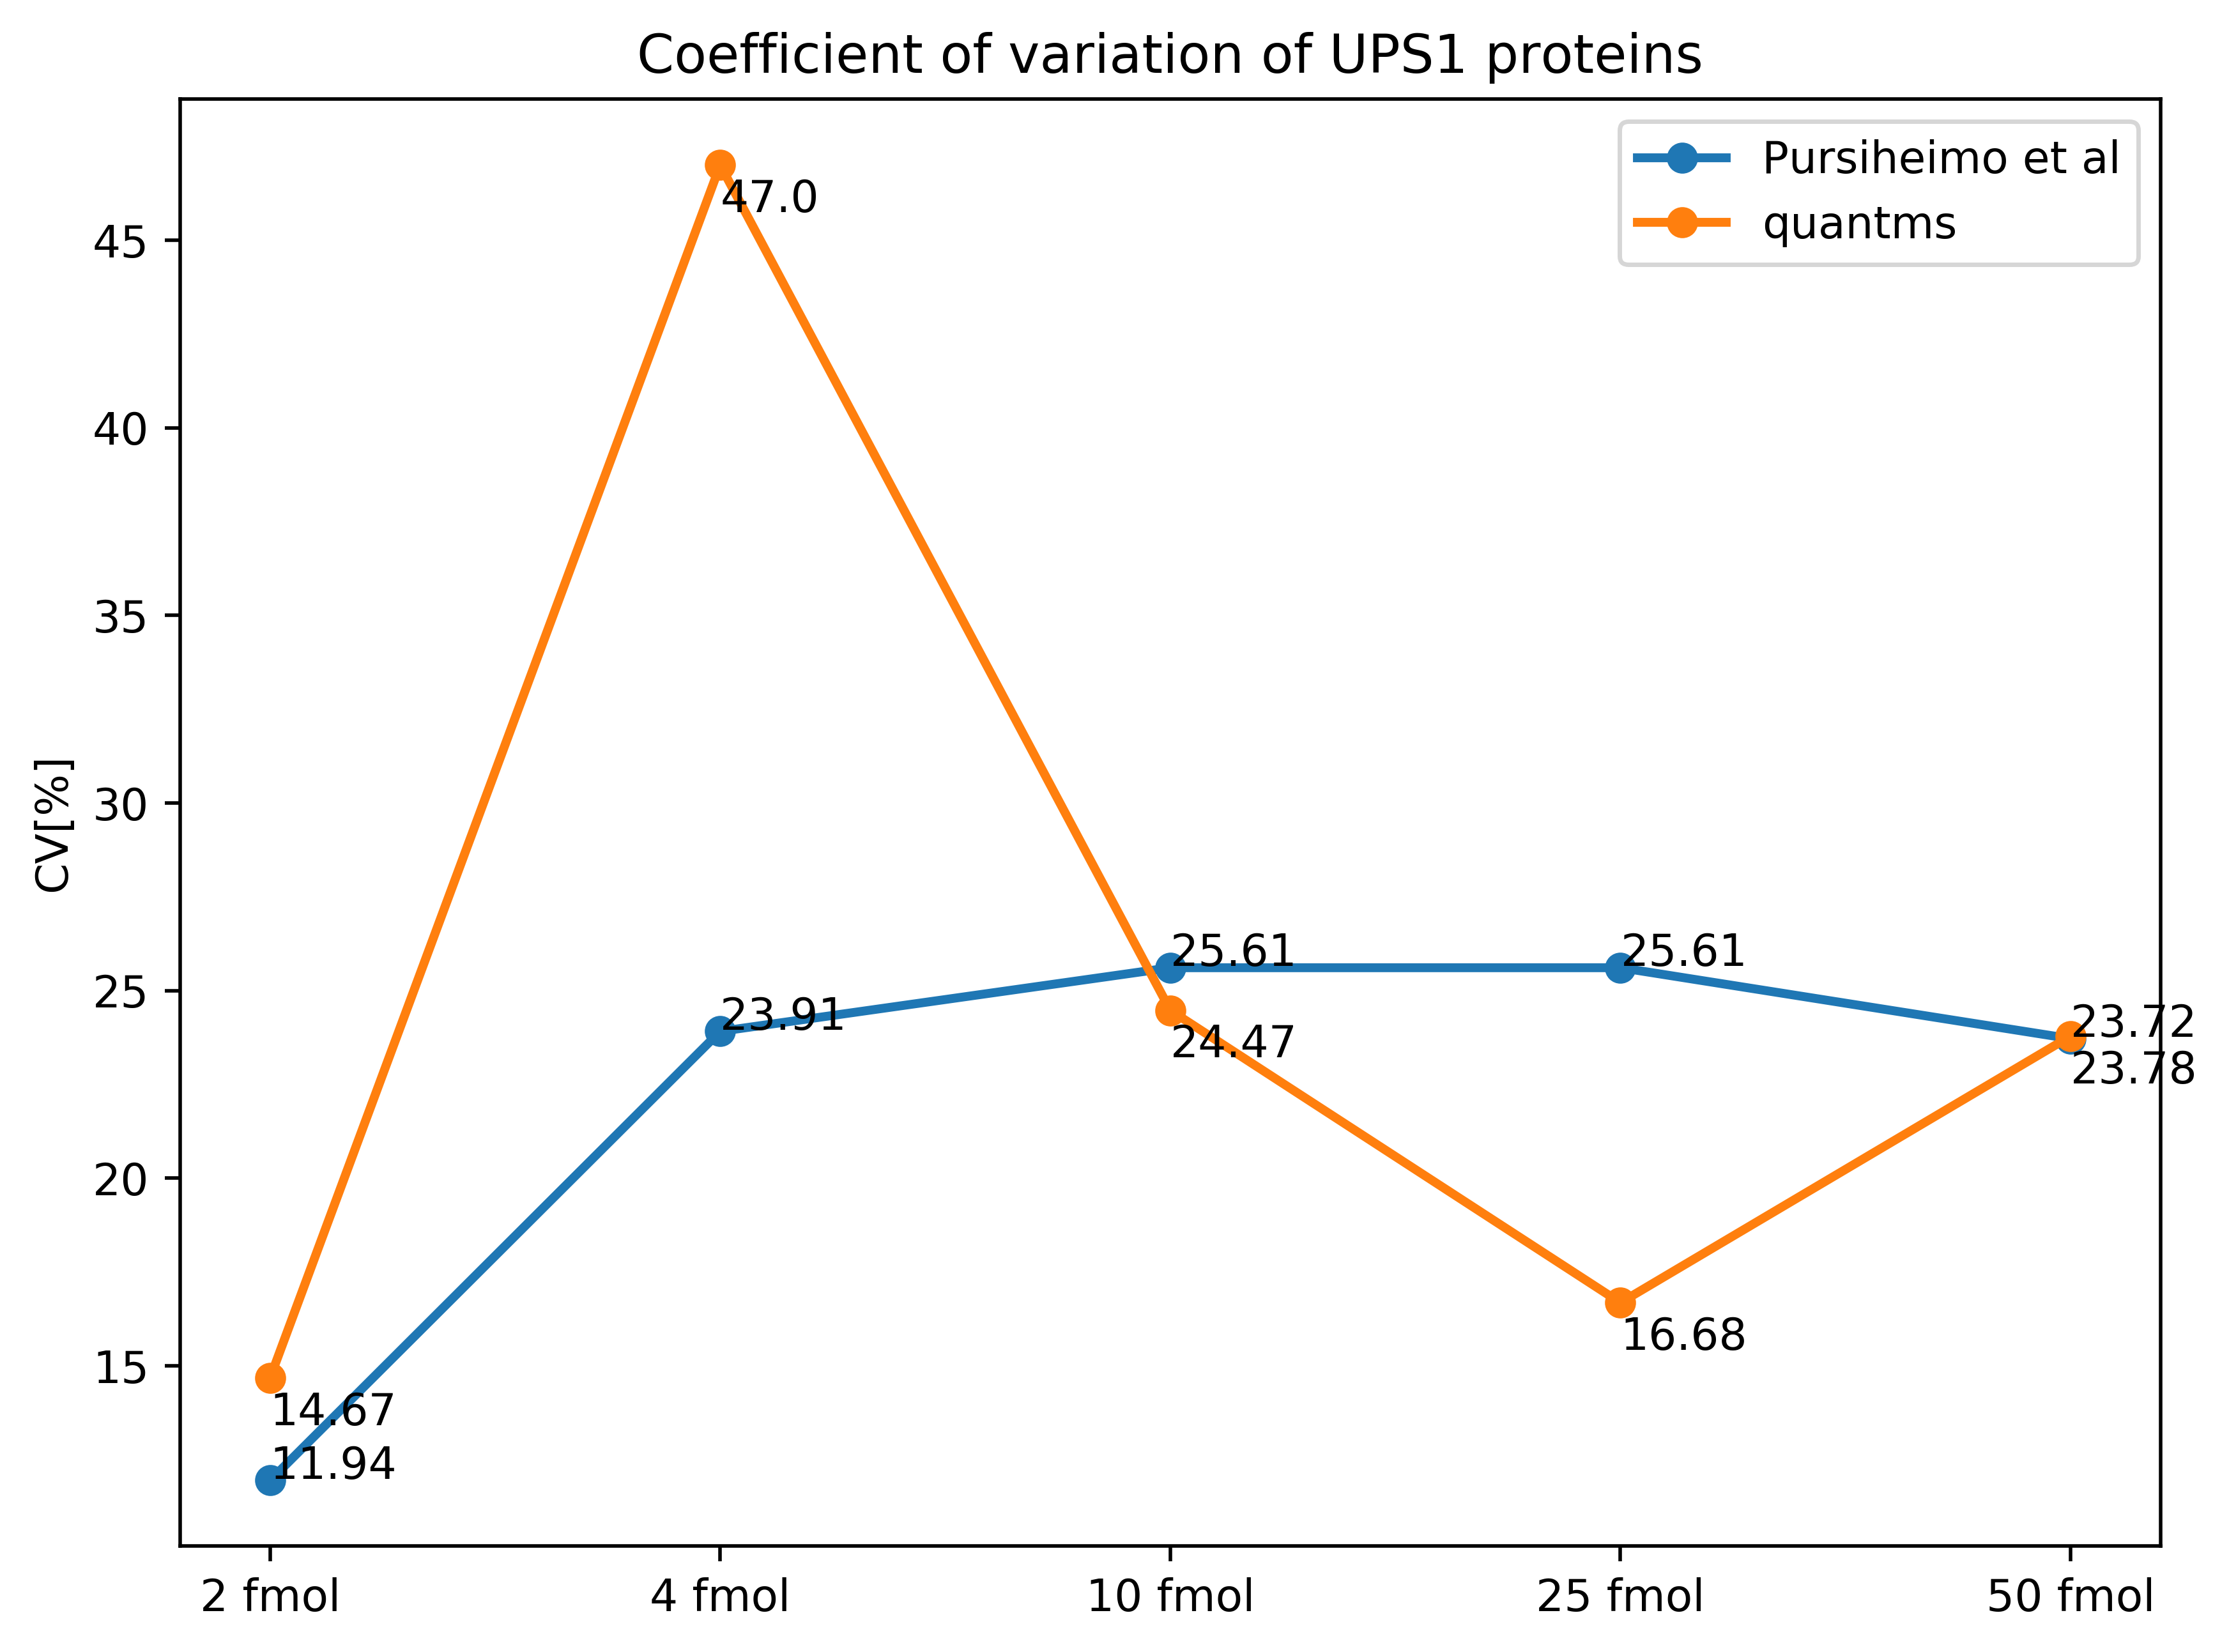

In [34]:
# original result
original_ups_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]", "HUE"])
original_spiked = original[original['Accession'].str.contains('ups')]
for Protein in np.unique(original_spiked['Accession']):
    spec_protein = original_spiked.loc[original_spiked['Accession'] == Protein]
    
    t = ("|".join(spec_protein.iloc[0, 3:6].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_ups_cv = original_ups_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 3], 
                   'TechRep2': spec_protein.iloc[0, 4], 'TechRep3': spec_protein.iloc[0, 5], 
                   'Condition': "2 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 6:9].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_ups_cv = original_ups_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 6], 
                   'TechRep2': spec_protein.iloc[0, 7], 'TechRep3': spec_protein.iloc[0, 8], 
                   'Condition': "4 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 9:12].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_ups_cv = original_ups_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 9], 
                   'TechRep2': spec_protein.iloc[0, 10], 'TechRep3': spec_protein.iloc[0, 11], 
                   'Condition': "10 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 9:12].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_ups_cv = original_ups_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 12], 
                   'TechRep2': spec_protein.iloc[0, 13], 'TechRep3': spec_protein.iloc[0, 14], 
                   'Condition': "25 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 15:18].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_ups_cv = original_ups_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 15], 
                   'TechRep2': spec_protein.iloc[0, 16], 'TechRep3': spec_protein.iloc[0, 17], 
                   'Condition': "50 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    
    
# quantms
quantms_ups_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]", "HUE"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("UPS")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        quantms_ups_cv = quantms_ups_cv.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean), "HUE": "quantms"}, ignore_index=True)

        
# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(original_ups_cv["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace(" fmol","")))
for condition in conditions:
    cvs.append(np.mean(original_ups_cv[original_ups_cv['Condition'] == condition]["CV[%]"]))
plt.plot(range(5), cvs, linewidth=2, marker='o', markersize=6)    
for i in range(5):
    plt.text(i, cvs[i]+0.05, round(cvs[i], 2))        
    
    
# calcualte average CV in UPS1 proteins without missing value
cvs = []
conditions = np.unique(quantms_ups_cv["Condition"])
conditions = sorted(conditions, key= lambda x: int(x.replace("CT=Mixture;CN=UPS1;QY=","").replace("fmol", "")))
for condition in conditions:
    cvs.append(np.mean(quantms_ups_cv[quantms_ups_cv['Condition'] == condition]["CV[%]"]))
    xticks.append(condition.replace("CT=Mixture;CN=UPS1;QY=",""))
    
plt.plot(range(5), cvs, linewidth=2, marker='o', markersize=6)
plt.xticks(range(5), xticks)
for i in range(5):
    plt.text(i, cvs[i] - 1.25, round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of UPS1 proteins')
plt.legend(['Pursiheimo et al', "quantms"])
plt.show()

#### Calcaulate CV of backgroud Proteins

In [38]:
original_background_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]", "Hue"])
original_background = original[-original['Accession'].str.contains('ups')]
for Protein in np.unique(original_background['Accession']):
    spec_protein = original_background.loc[original_background['Accession'] == Protein]
            
    t = ("|".join(spec_protein.iloc[0, 3:6].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 3], 
                   'TechRep2': spec_protein.iloc[0, 4], 'TechRep3': spec_protein.iloc[0, 5], 
                   'Condition': "2 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 6:9].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 6], 
                   'TechRep2': spec_protein.iloc[0, 7], 'TechRep3': spec_protein.iloc[0, 8], 
                   'Condition': "4 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 9:12].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 9], 
                   'TechRep2': spec_protein.iloc[0, 10], 'TechRep3': spec_protein.iloc[0, 11], 
                   'Condition': "10 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 9:12].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 12], 
                   'TechRep2': spec_protein.iloc[0, 13], 'TechRep3': spec_protein.iloc[0, 14], 
                   'Condition': "25 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
    t = ("|".join(spec_protein.iloc[0, 15:18].tolist())).replace(",", ".").split("|")
    t = list(map(float, t))
    mean = np.mean(t)
    std = np.std(t)
    original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':spec_protein.iloc[0, 15], 
                   'TechRep2': spec_protein.iloc[0, 16], 'TechRep3': spec_protein.iloc[0, 17], 
                   'Condition': "50 fmol", "CV[%]": 100 * (std / mean), "HUE": "Pursiheimo et al"}, ignore_index=True)
            
conditions = np.unique(original_background_cv["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace(" fmol","")))
for condition in conditions:
    print(condition + " mean cv: %f" %(np.mean(original_background_cv[original_background_cv['Condition'] == condition]["CV[%]"])))
    

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


2 fmol mean cv: 17.714538
4 fmol mean cv: 14.365905
10 fmol mean cv: 32.027384
25 fmol mean cv: 32.027384
50 fmol mean cv: 20.851188


#### At high concentrations, quantms have a smaller mean cv.

CT=Mixture;CN=UPS1;QY=10 fmol mean cv: 33.172792
CT=Mixture;CN=UPS1;QY=2 fmol mean cv: 20.368996
CT=Mixture;CN=UPS1;QY=25 fmol mean cv: 23.905228
CT=Mixture;CN=UPS1;QY=4 fmol mean cv: 20.910747
CT=Mixture;CN=UPS1;QY=50 fmol mean cv: 19.671714


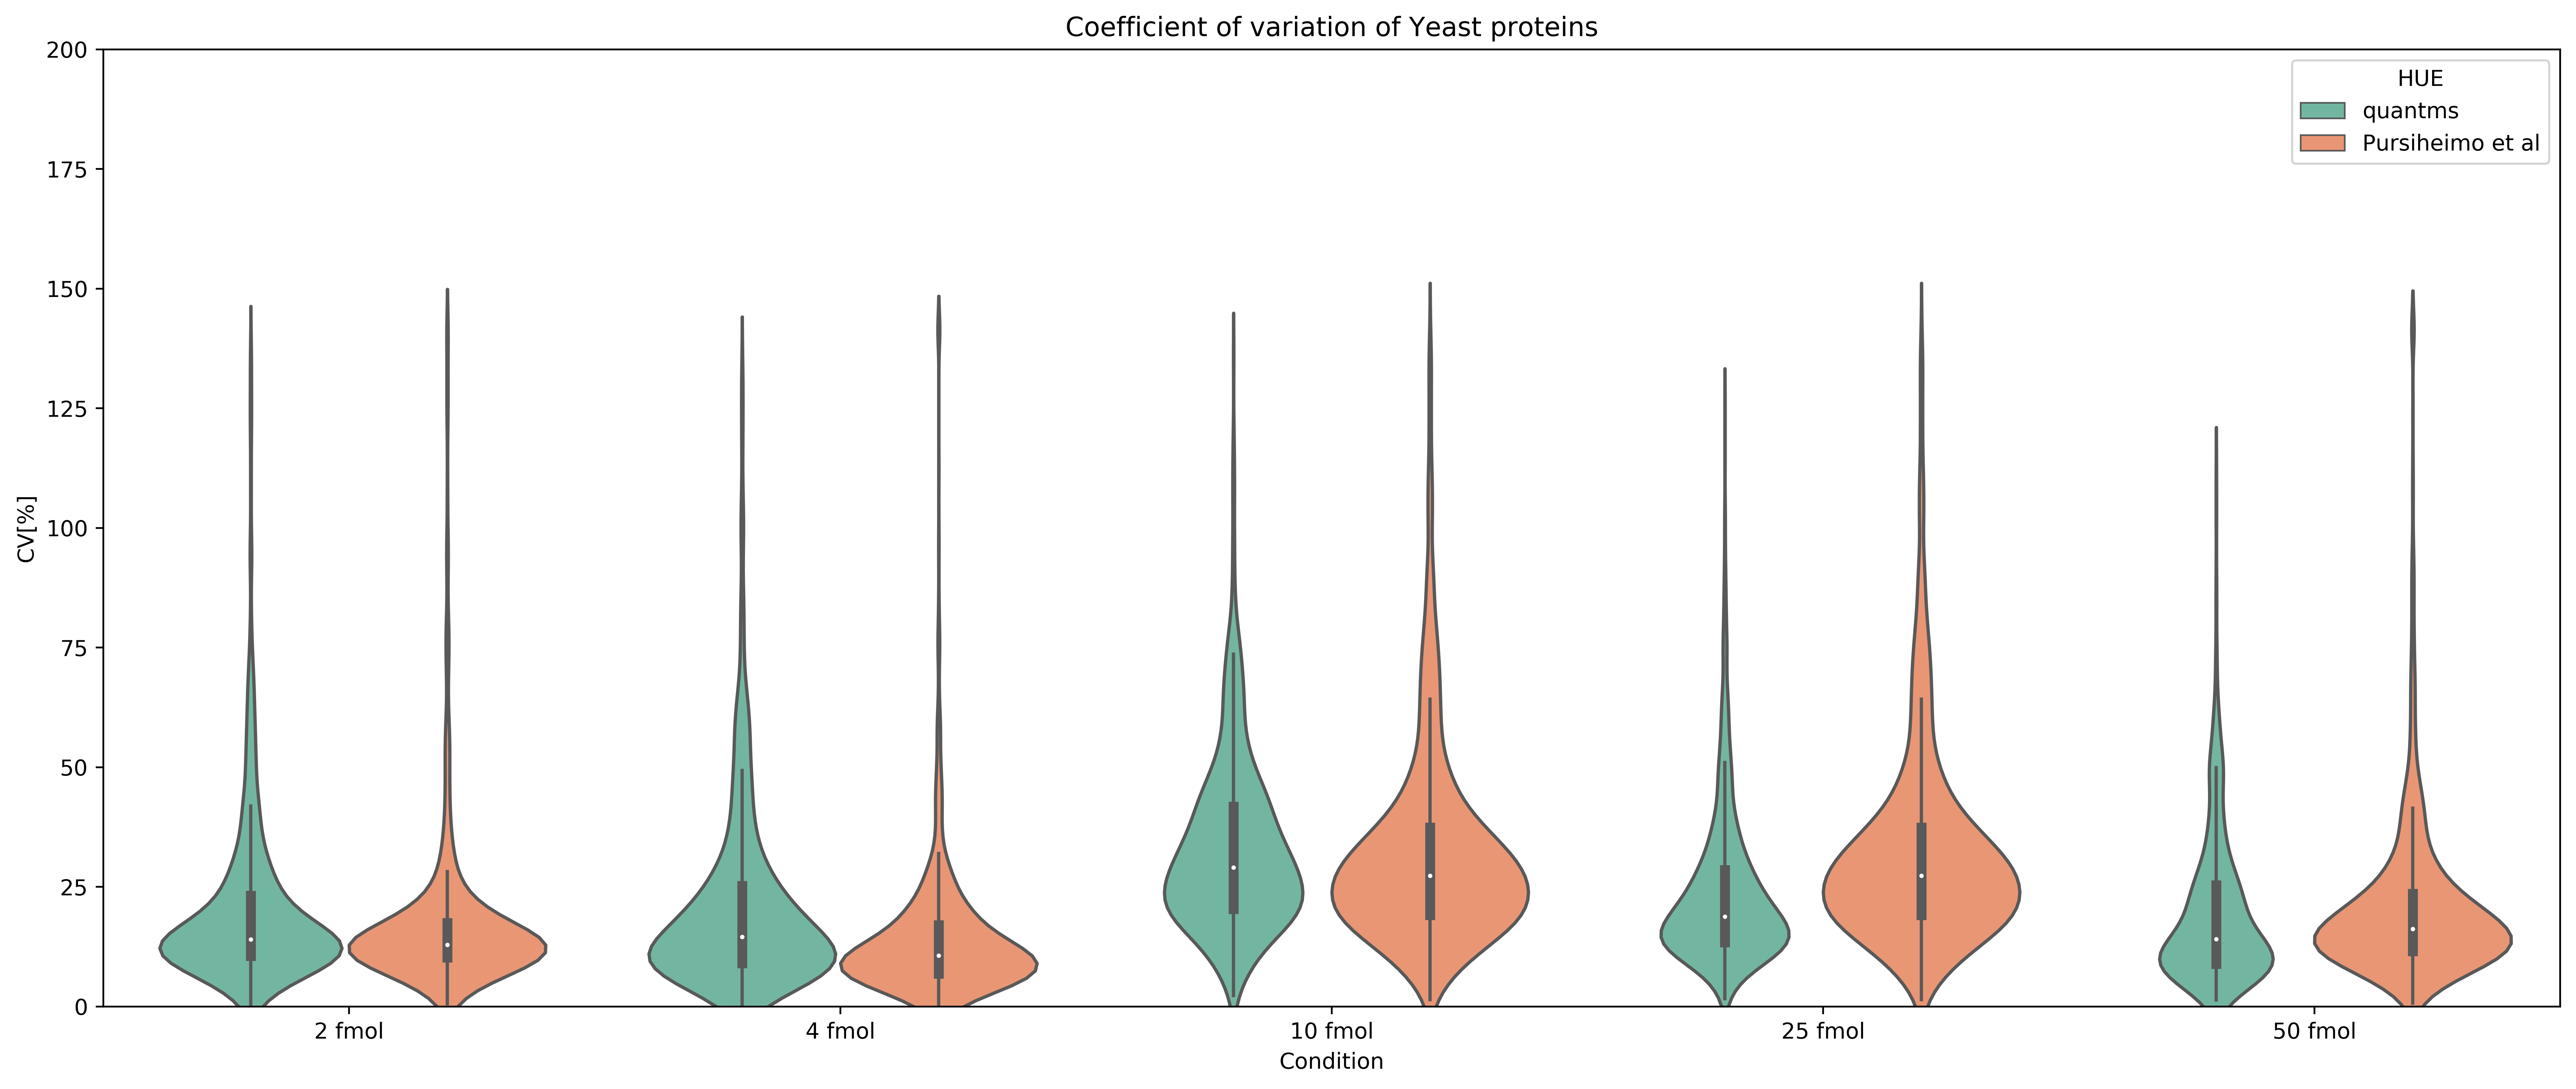

In [41]:
quantms_background_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]", "HUE"])
quantms_background = quantms[-quantms['ProteinName'].str.contains("UPS")]

for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    cvs = []
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            tech_intensity.append(np.sum(quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]['Intensity']))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        cvs.append(100 * (std / mean))
        quantms_background_cv = quantms_background_cv.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition.replace("CT=Mixture;CN=UPS1;QY=",""), "CV[%]": 100 * (std / mean), "HUE": "quantms"}, ignore_index=True)

    print(condition + " mean cv: %f" %(np.mean(cvs)))
    
all_background_cv = quantms_background_cv.append(original_background_cv)
plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Yeast proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=all_background_cv, scale= "count", palette="Set2", hue="HUE",
               order=['2 fmol', '4 fmol', '10 fmol', '25 fmol', '50 fmol'])

plt.show()

### QCplots and Calculate FC

In [49]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
library("dplyr")

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om$Condition <- sub("CT=Mixture;CN=UPS1;QY=", "", raw.om$Condition)

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-11 22:29:26] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-11 22:29:26] ** Fractionation handled.
INFO  [2021-12-11 22:29:27] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-12-11 22:29:27] ** Log2 intensities under cutoff = 15.042  were considered as censored missing values.
INFO  [2021-12-11 22:29:27] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-12-11 22:29:27] ** Use all features that the dataset originally has.
INFO  [2021-12-11 22:29:28] 
 # proteins: 1625
 # peptides per protein: 1-101
 # features per peptide: 1-1
INFO  [2021-12-11 22:29:28] Some proteins have only one feature: 
 P62988ups|UBIQ_HUMAN_UPS,
 sp|O13516|RS9A_YEAST,
 sp|O13585|YP089_YEAST,
 sp|O43137|YB085_YEAST,
 sp|P00724|INV2_YEAST ...
INFO  [2021-12-11 22:29:28] 
                    10 fmol 2 fmol 25 fmol 4 fmol 50 fmol
             # runs       3      3       3      3       3
 

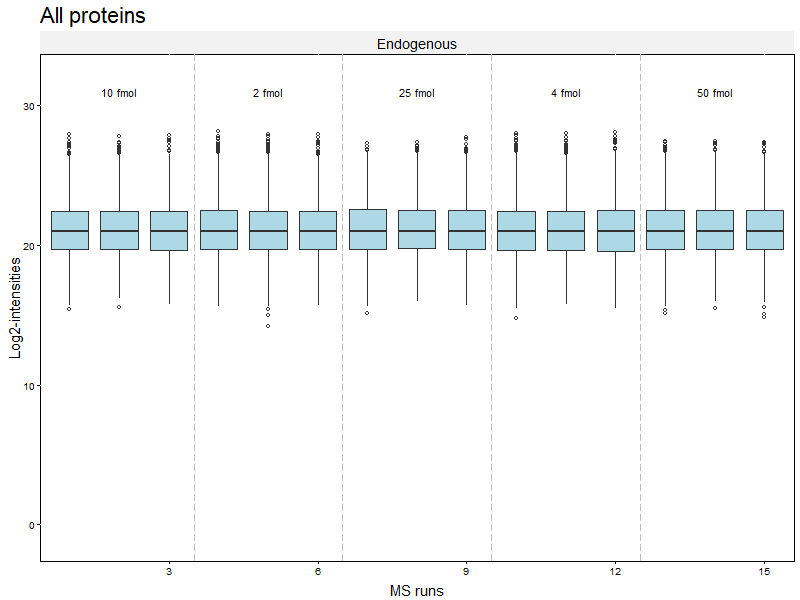

In [50]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|P23201|SPA2_YEAST"
  |===================                                                   |  26%


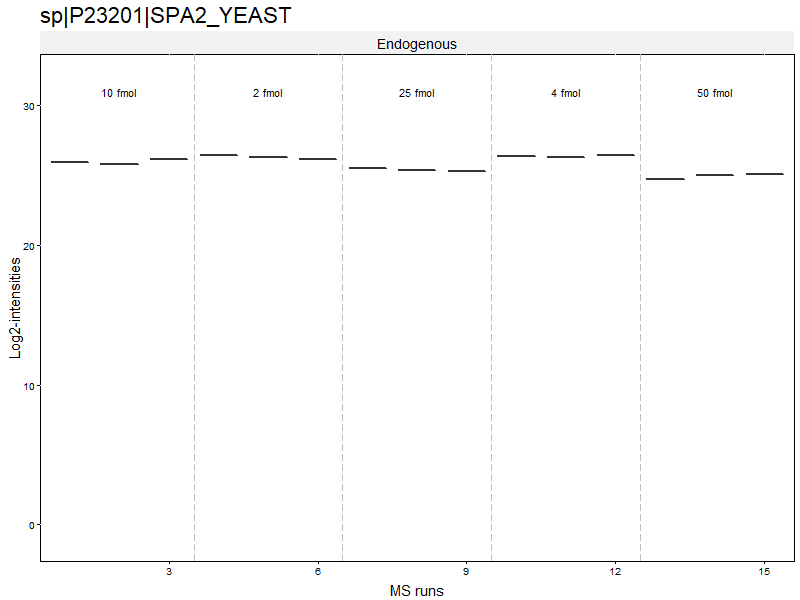

In [51]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


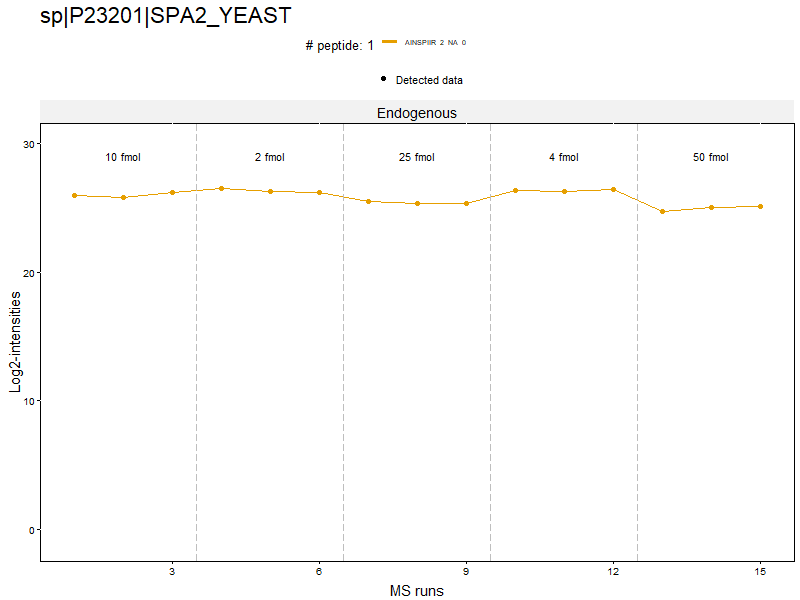

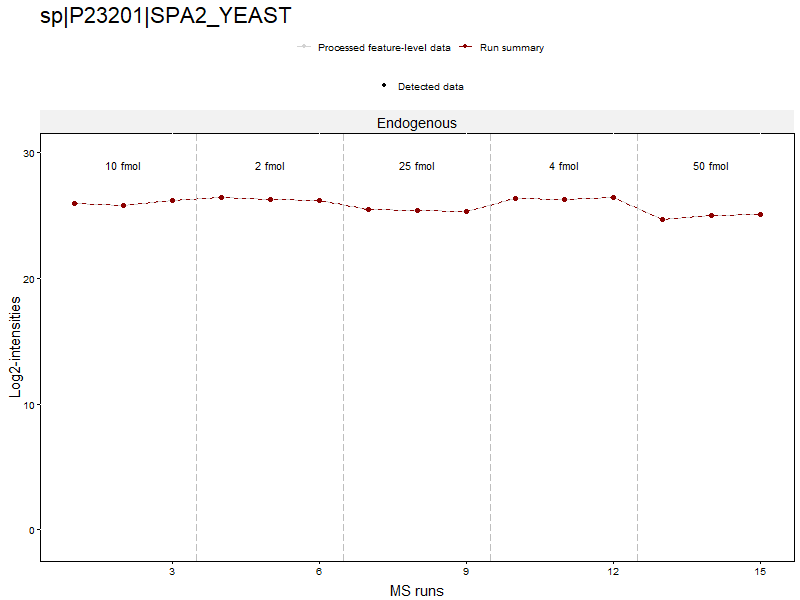

In [52]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |=                                                                     |   1%


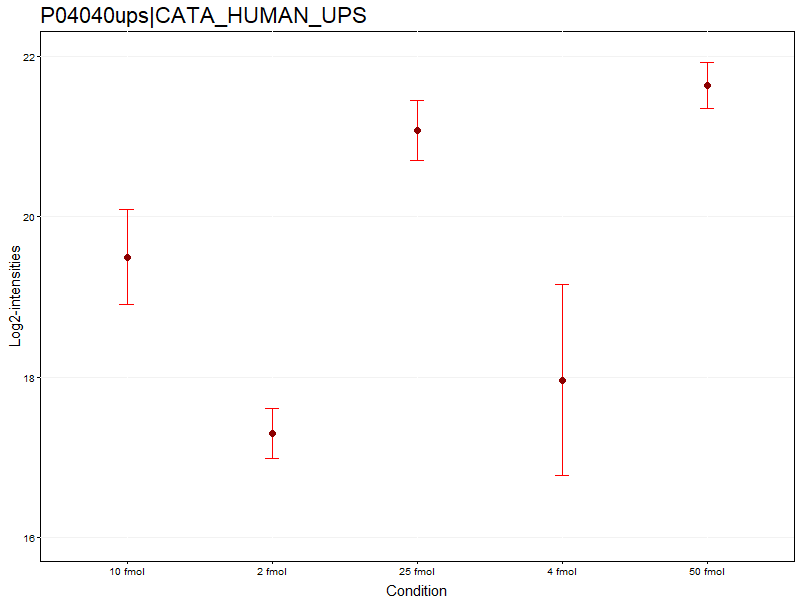

In [53]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("P04040ups|CATA_HUMAN_UPS", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [54]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,-1,0,0,-1,0,0,1,1,0,0,0,0,-1,0,0,-1,0,-1,-1,-1,0,0,0,1,1,1,0,0,0,0,0,-1,0,0,-1,0,-1,0,1,1,1,1,1,0,0,0,0,0,0)
comparison <- matrix(comparison_matrix, nrow=10)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2")
print(comparison)

[1] "10 fmol" "2 fmol"  "25 fmol" "4 fmol"  "50 fmol"
       10 fmol 2 fmol 25 fmol 4 fmol 50 fmol
50vs25       0      0      -1      0       1
50vs10      -1      0       0      0       1
50vs4        0      0       0     -1       1
50vs2        0     -1       0      0       1
25vs10      -1      0       1      0       0
25vs4        0      0       1     -1       0
25vs2        0     -1       1      0       0
10vs4        1      0       0     -1       0
10vs2        1     -1       0      0       0
4vs2         0     -1       0      1       0


In [55]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-12-11 22:29:55]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-12-11 22:30:11]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### Since the aim of most proteomcis studies is to analyze differential protein expression by revealing significant quantitative differences between complex proteomes, protein quantificaiton and ratio accurancy in pairwise comparisons are important factos to consider. Therefore calculated the log2FC olf protein intensities for each possible pair of the 5 UPS1 concentrations testded (a total of 10 pairwise comparisons)

#### Computing the error between the experimental FC and expected FC. There are two metrcis including MAPE and MSE. The former is a relative error. The latter is a absolute error.

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of UPS1 quantified proteins

In [56]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.738544,0.309611,2.385390,10.0,3.825863e-02,1.394082e-01,NaN,0.231481,0.231481
1,O00762ups|UBE2C_HUMAN_UPS,50vs10,2.170214,0.309611,7.009481,10.0,3.673366e-05,5.229424e-04,NaN,0.361111,0.361111
2,O00762ups|UBE2C_HUMAN_UPS,50vs4,4.698741,0.309611,15.176262,10.0,3.124856e-08,1.925263e-06,NaN,0.527778,0.527778
3,O00762ups|UBE2C_HUMAN_UPS,50vs2,5.218870,0.309611,16.856206,10.0,1.134062e-08,9.951390e-07,NaN,0.546296,0.546296
4,O00762ups|UBE2C_HUMAN_UPS,25vs10,1.431670,0.309611,4.624091,10.0,9.446630e-04,1.614401e-02,NaN,0.444444,0.444444


#### Most of MAPE values are below 20%. 

[59.31717143955937, 25.670093111526807, 15.285037456489716, 17.81579630578015, 13.756354142363728, 14.180110929208613, 13.77827956347849, 21.910716426036497, 17.1150590550926, 37.48849615483726]


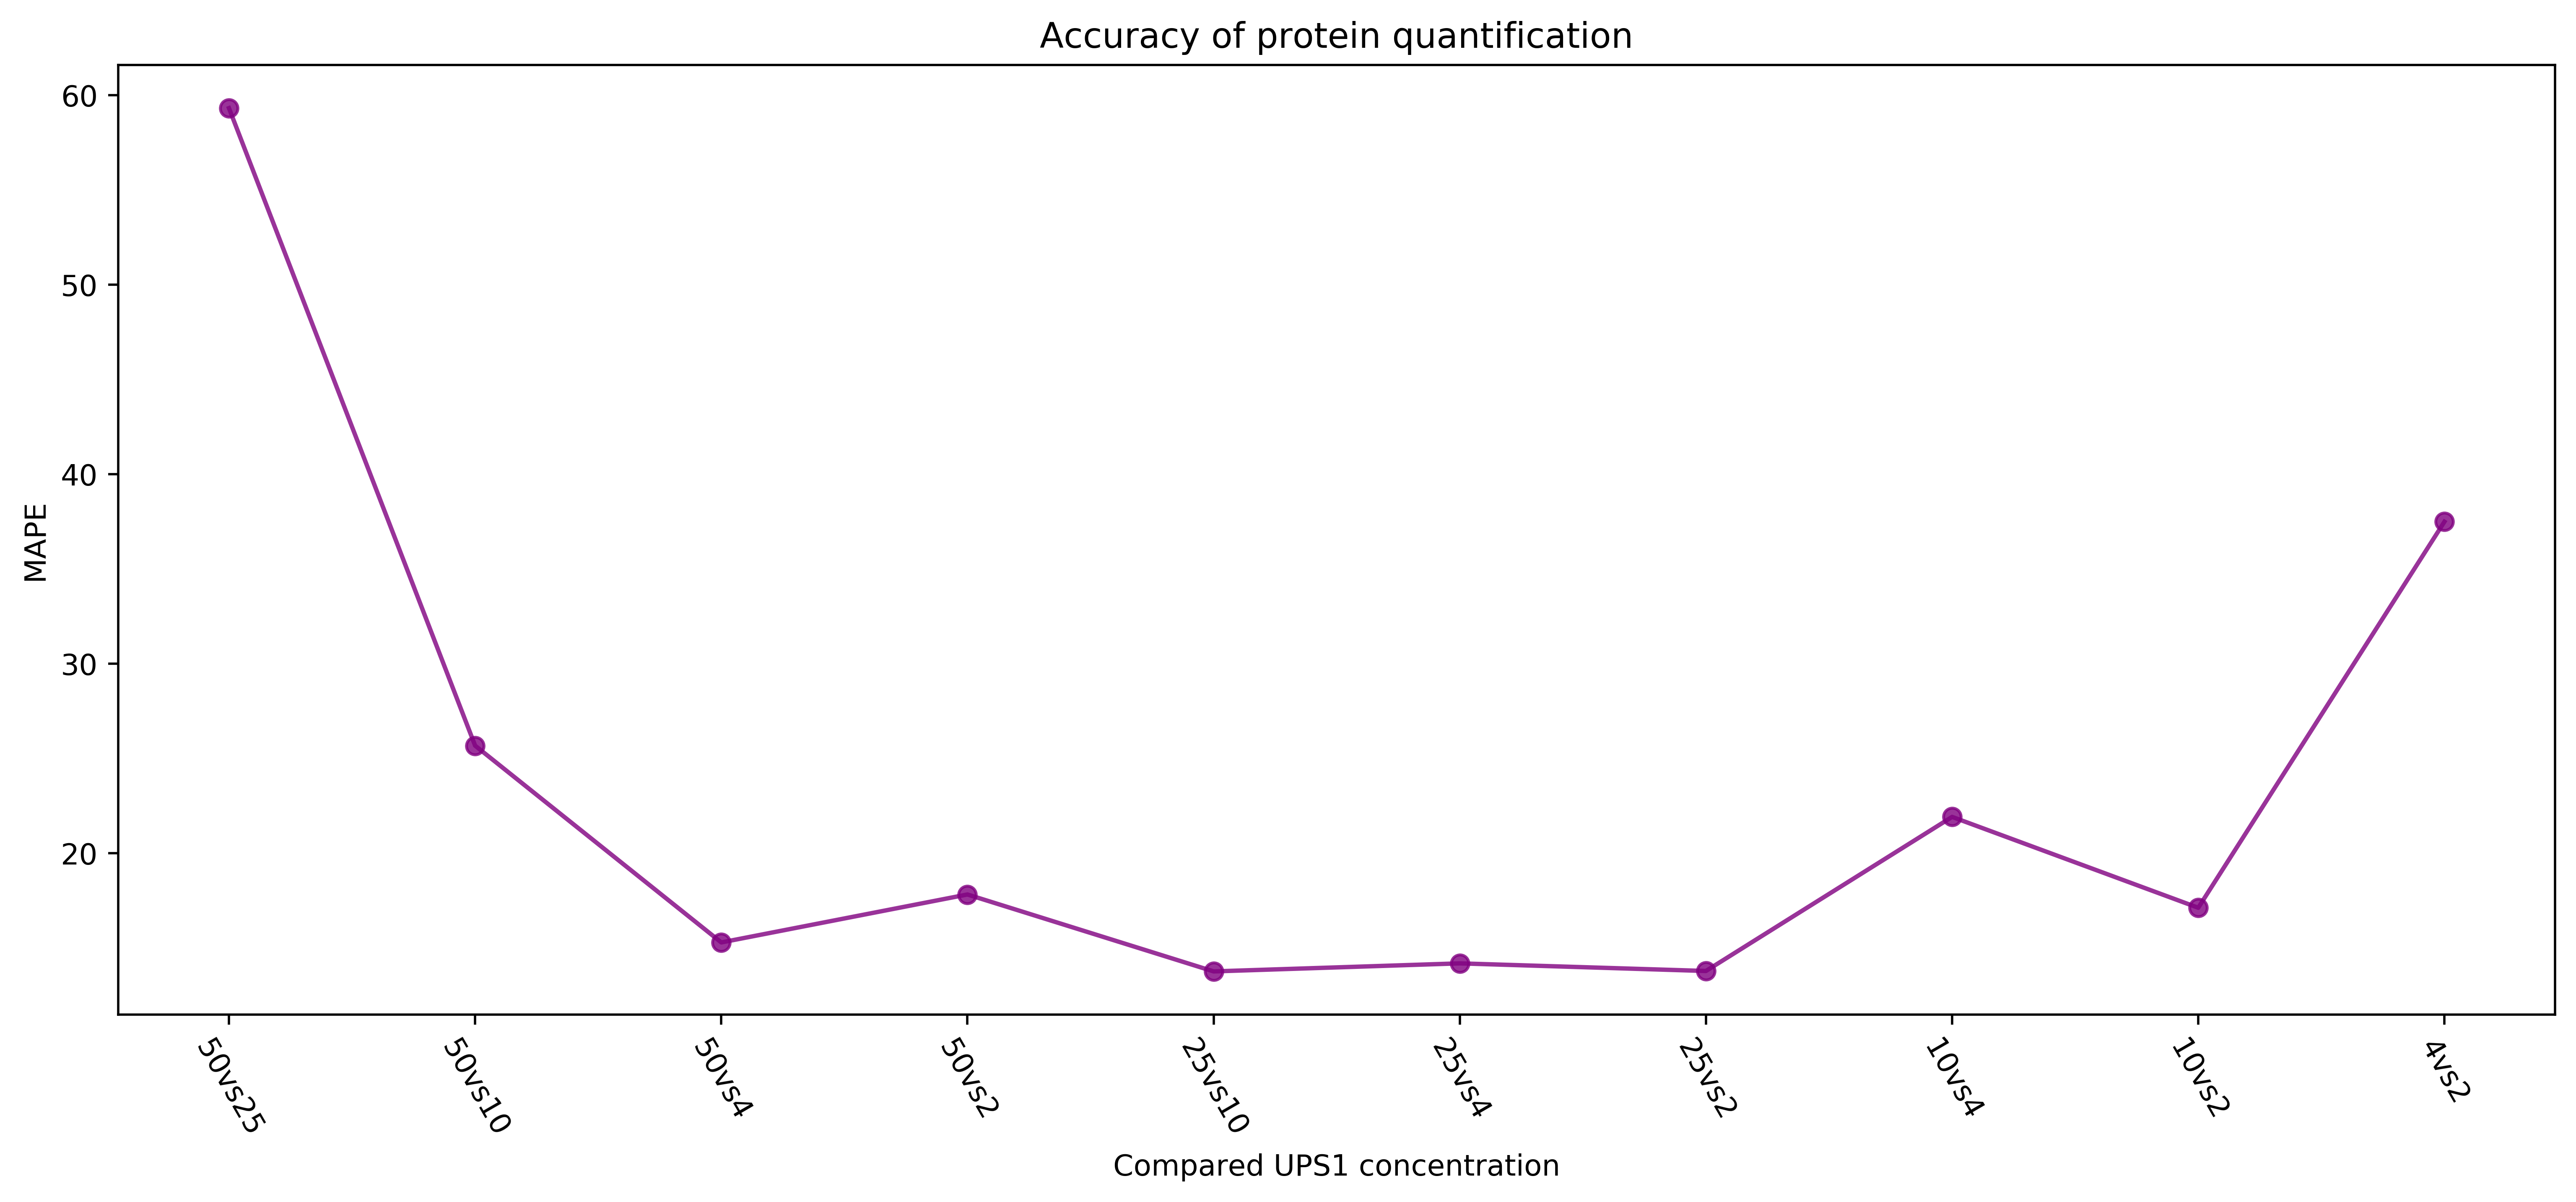

In [57]:
# calculate MAPE
import math

MAPE = []
ups_comp = compar_res[compar_res['Protein'].str.contains("UPS")]
conditions = ["50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2"]
for condition in conditions:
    t = ups_comp[ups_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        experimental_log2FC = t[t['Protein'] == protein]['log2FC']
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
        ape.append(np.abs(expected_log2FC - experimental_log2FC) / expected_log2FC * 100)
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(10), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(10), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared UPS1 concentration")
plt.ylabel("MAPE[%]")
plt.xticks(rotation=300)
plt.show()

####  The MSE of the logFC estimates in the all two-group comparisons. For spiked-in proteins, quantms had a very low mean MSE of 0.35. And the mean MSE of 0.61 is lower than other workflows such as another OpenMS(0.63)、PEAKS(0.64). 

0.1681868650744473
0.2506565795349214
0.35045693526239535
0.6093065020088871
0.5413431551574488
1.5105364230931968


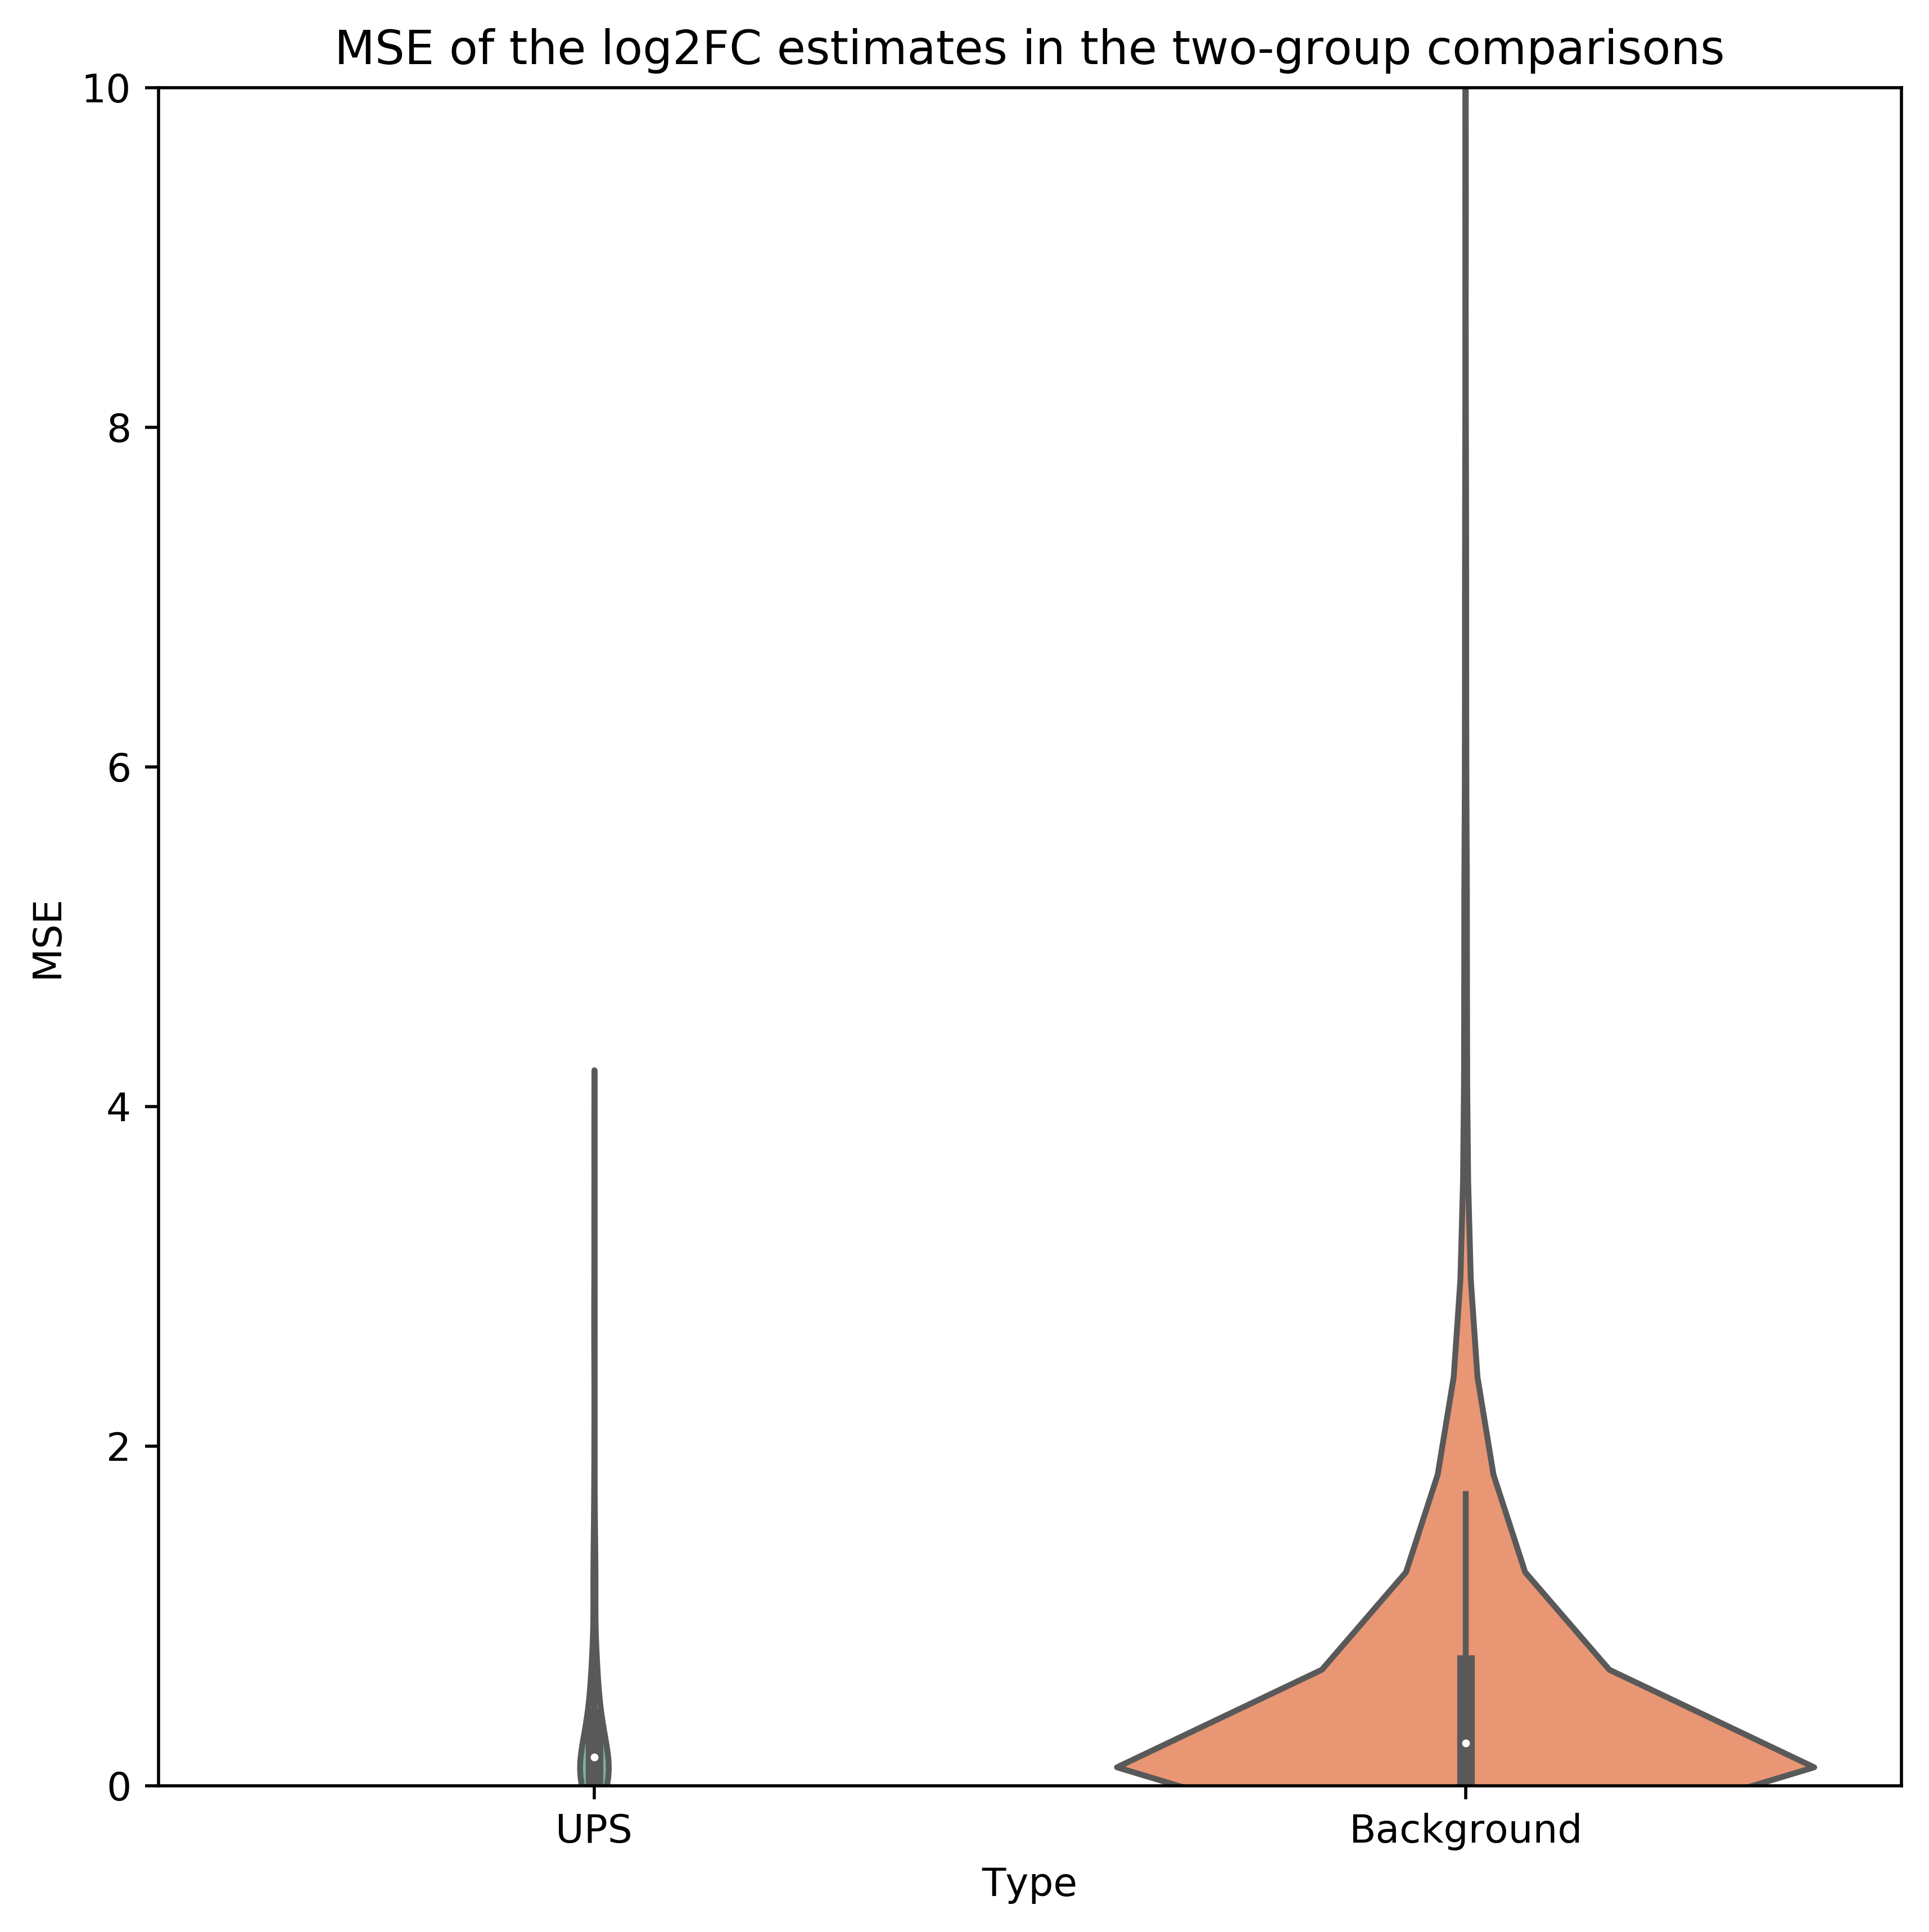

In [59]:
MSEs = pd.DataFrame(columns=["Type", "MSE"])

for _, row in compar_res.iterrows():
    if "Missing" in str(row['issue']):
        continue
    experimental_log2FC = row['log2FC']
    condition = row['Label']
    if "UPS" in row['Protein']:
        datatype = "UPS"
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
    else:
        expected_log2FC = 0
        datatype = "Background"
    mse = (experimental_log2FC - expected_log2FC) ** 2
    MSEs = MSEs.append({'Type': datatype, "MSE": mse}, ignore_index=True)
    
plt.figure(figsize=(8,8), dpi=500)
plt.ylim(0, 10)
plt.title("MSE of the log2FC estimates in the two-group comparisons")
sns.violinplot(x = "Type", y="MSE", data=MSEs, scale= "count", palette="Set2")
print(np.median(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.median(MSEs[MSEs['Type'] != "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] != "UPS"]['MSE']))
print(np.std(MSEs[MSEs['Type'] == "UPS"]['MSE']))
print(np.std(MSEs[MSEs['Type'] != "UPS"]['MSE']))
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Proteins are typically chosen for follow-up experiment and validation based on the significance of their p-values or adj-pvalue/ q-value, especially for differential protein analysis. Thus, calculated the ROC curves based on adj-pvalue generated in the msstats.

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [60]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,O00762ups|UBE2C_HUMAN_UPS,50vs25,0.738544,0.309611,2.385390,10.0,3.825863e-02,1.394082e-01,NaN,0.231481,0.231481
1,O00762ups|UBE2C_HUMAN_UPS,50vs10,2.170214,0.309611,7.009481,10.0,3.673366e-05,5.229424e-04,NaN,0.361111,0.361111
2,O00762ups|UBE2C_HUMAN_UPS,50vs4,4.698741,0.309611,15.176262,10.0,3.124856e-08,1.925263e-06,NaN,0.527778,0.527778
3,O00762ups|UBE2C_HUMAN_UPS,50vs2,5.218870,0.309611,16.856206,10.0,1.134062e-08,9.951390e-07,NaN,0.546296,0.546296
4,O00762ups|UBE2C_HUMAN_UPS,25vs10,1.431670,0.309611,4.624091,10.0,9.446630e-04,1.614401e-02,NaN,0.444444,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
16245,sp|Q99383|HRP1_YEAST,25vs4,0.458336,0.272264,1.683425,10.0,1.232006e-01,1.590433e-01,NaN,0.666667,0.666667
16246,sp|Q99383|HRP1_YEAST,25vs2,0.451791,0.272264,1.659387,10.0,1.280264e-01,1.677189e-01,NaN,0.666667,0.666667
16247,sp|Q99383|HRP1_YEAST,10vs4,1.364495,0.272264,5.011658,10.0,5.281841e-04,2.784757e-03,NaN,0.500000,0.500000
16248,sp|Q99383|HRP1_YEAST,10vs2,1.357950,0.272264,4.987620,10.0,5.472346e-04,3.401441e-03,NaN,0.500000,0.500000


#### ROC curve: AUC is 0.80. Looks a bit low  in terms of other results. DOI: 10.1093/bib/bbx054

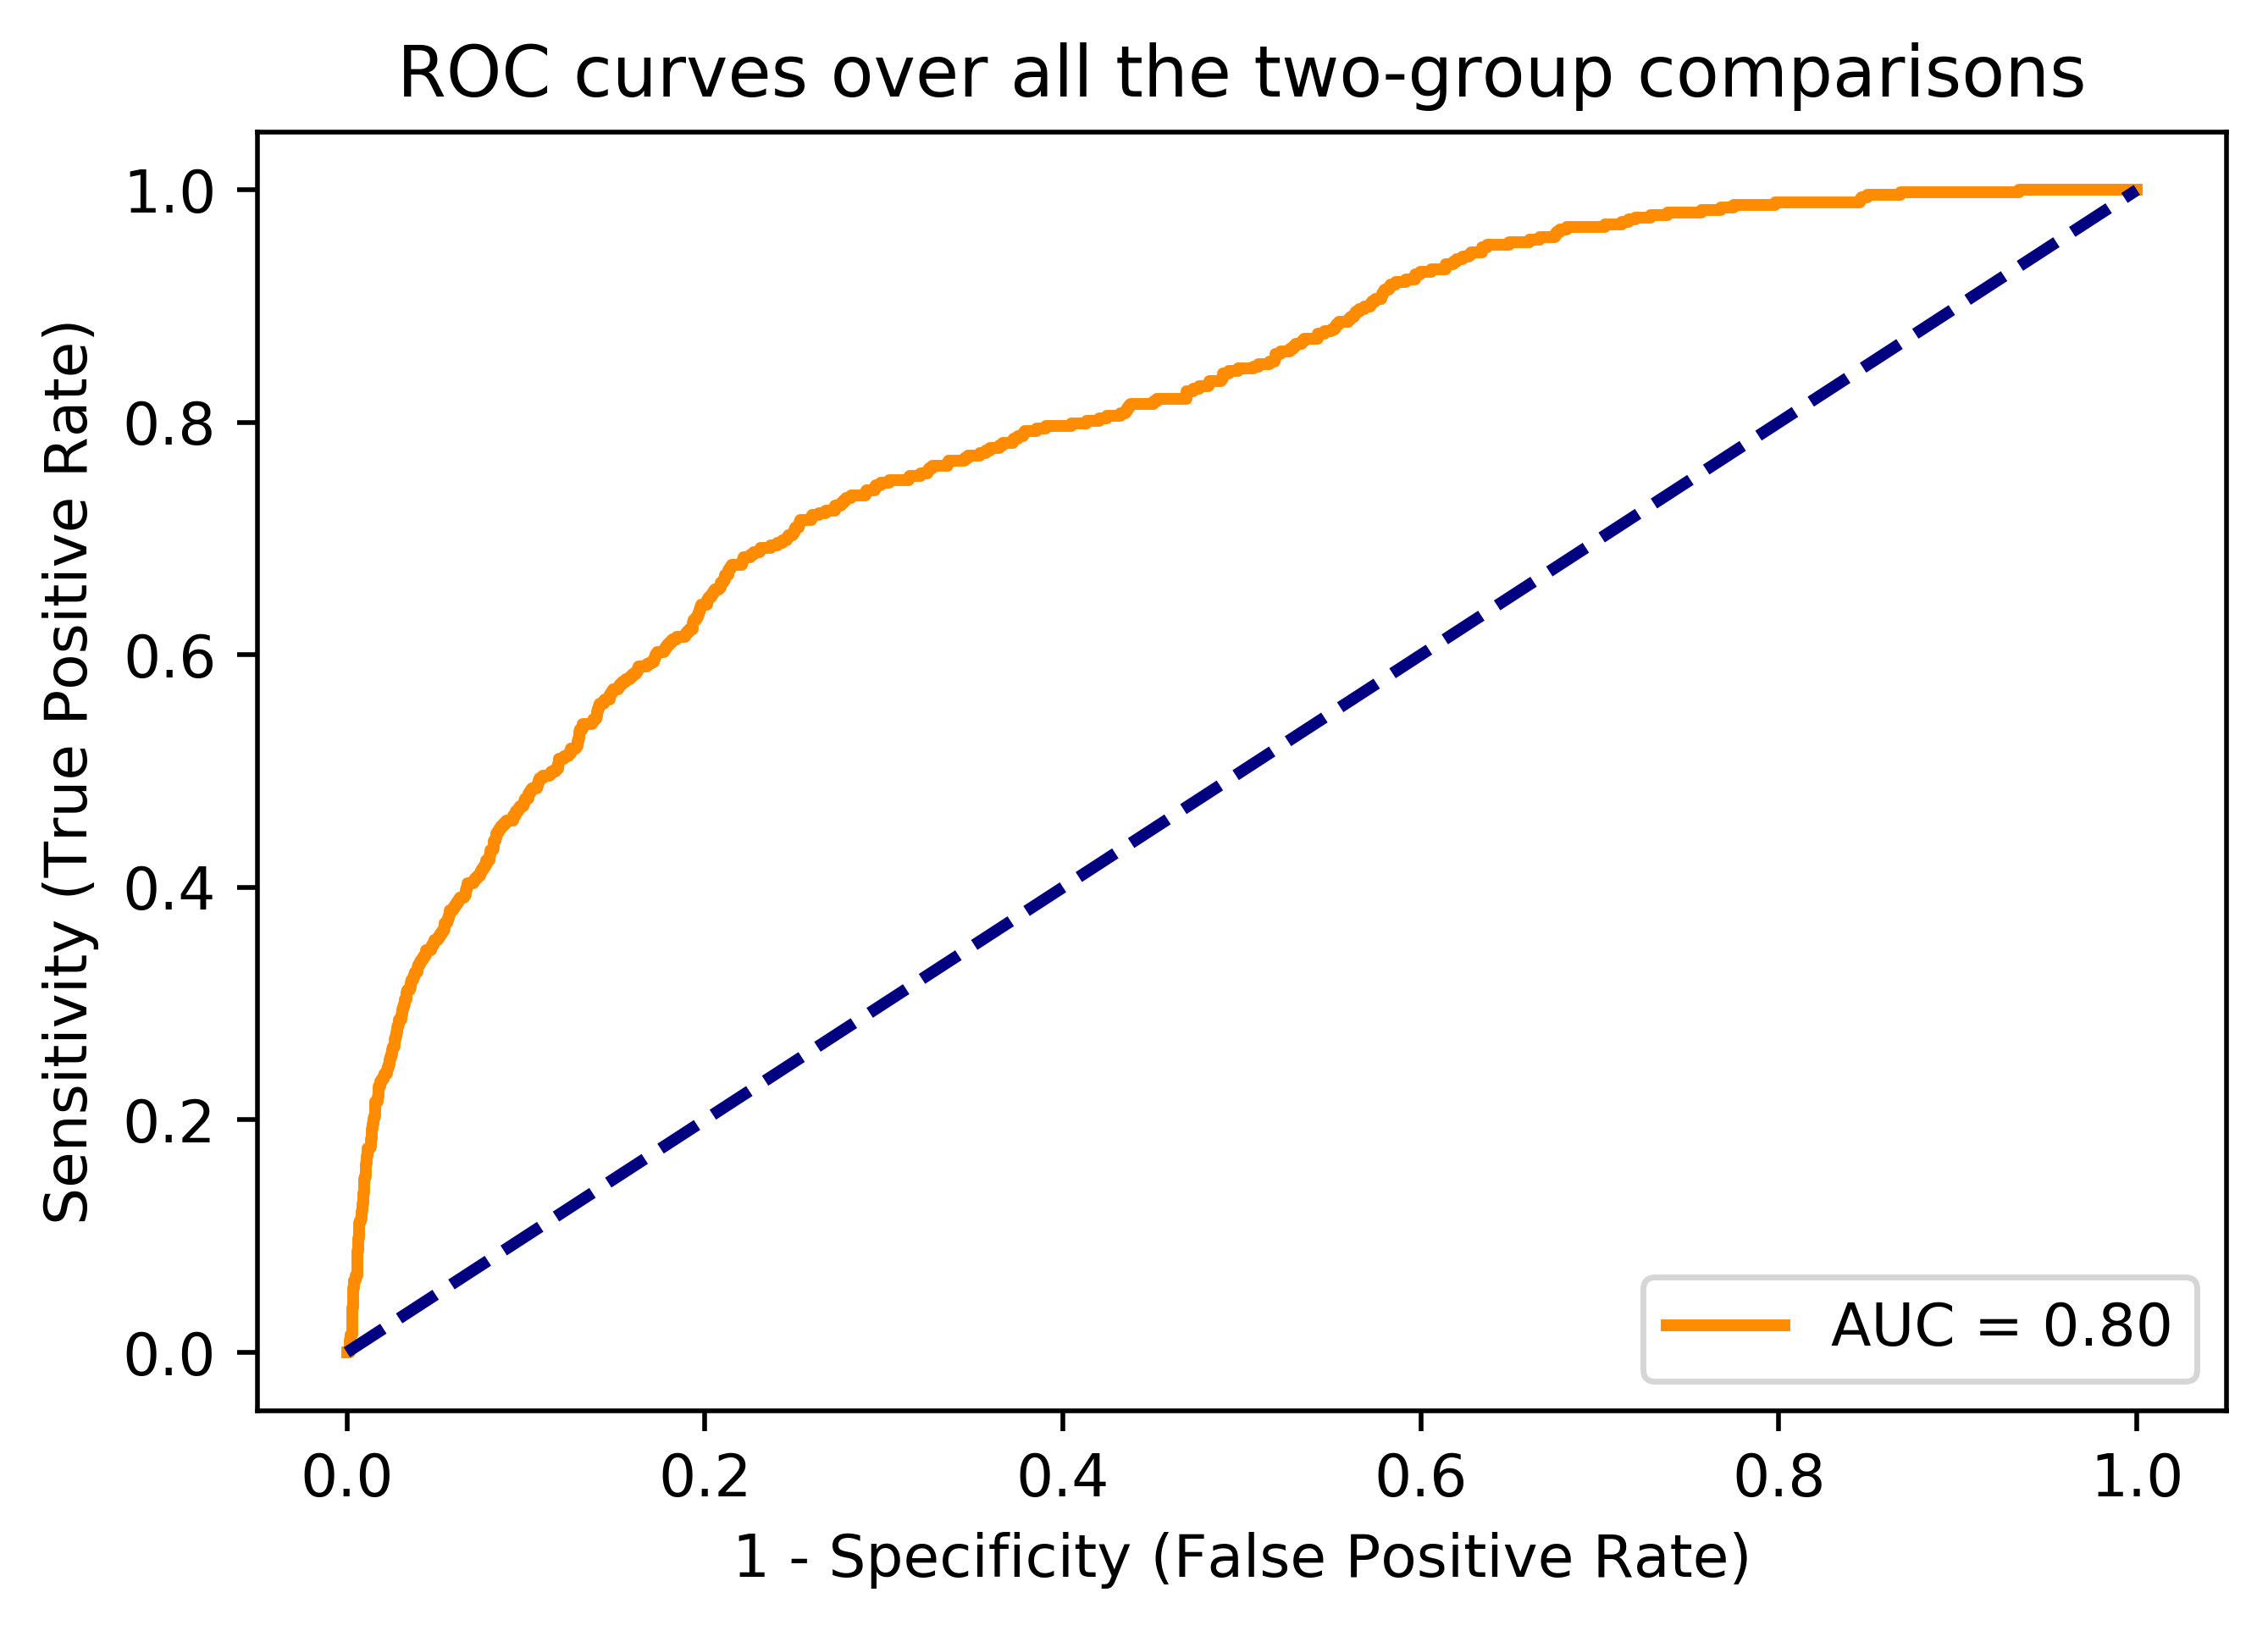

In [62]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['pvalue']
compar_res['y'] = compar_res['Protein'].map(lambda x: ("UPS" in x and 1) or ("UPS" not in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")


#### Calculating the total AUC seems arbitrary, because pvalue distribution may be difference between comparisons. And the differential expression proteins were detected in difference comparisons. Thus, pAUC metric is calculated

#### pAUCs within each comparison. quantms has a higher pAUC distribution  than 10.1021/acs.jproteome.5b00183.

Text(0.5, 1.0, 'pAUCs of each two-group comparison')

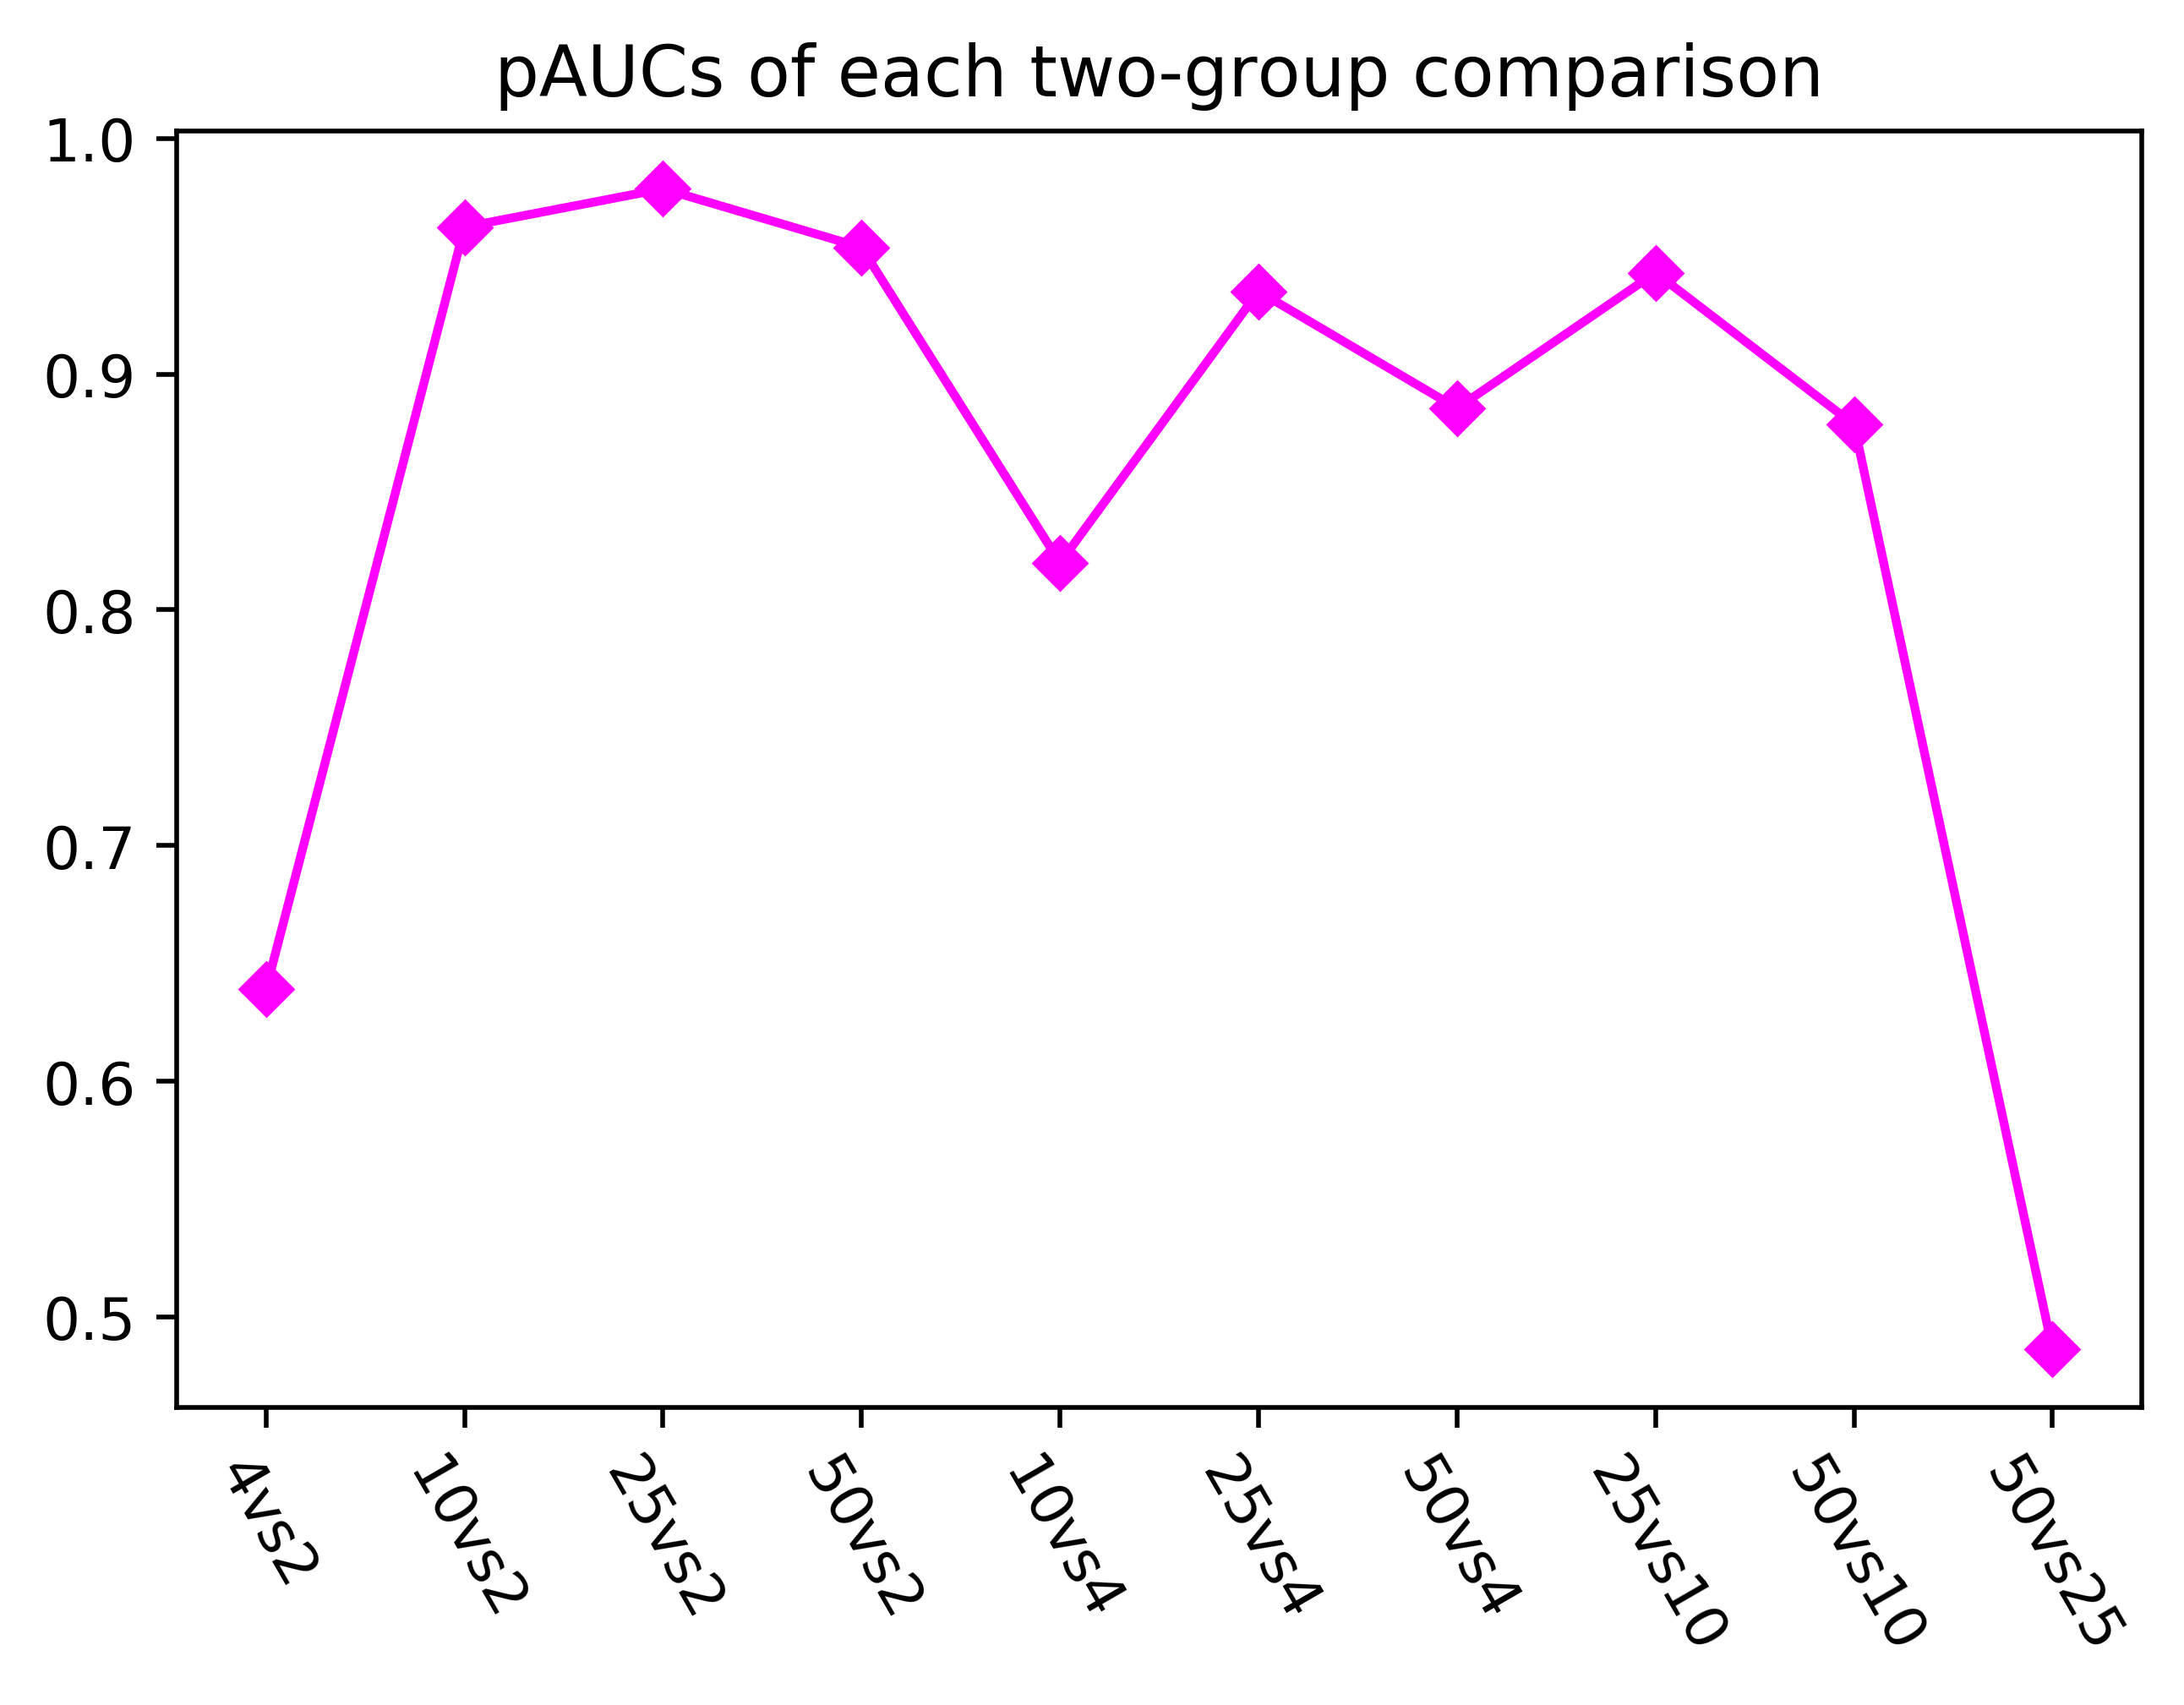

In [6]:
compar_res.head()

conditions = ["4vs2", "10vs2", "25vs2", "50vs2", "10vs4", "25vs4", "50vs4", "25vs10", "50vs10", "50vs25"]
paucs = []
for condition in conditions:
    comp_condition = compar_res[compar_res['Label'] == condition]
    fpr, tpr, thresholds = metrics.roc_curve(comp_condition['y'].tolist(), comp_condition['value'].tolist(), pos_label = 1)
    pauc = metrics.auc(fpr, tpr)
    paucs.append(pauc)

plt.figure(dpi=500)
plt.plot(range(10), paucs, 'rD-', color='magenta')
plt.xticks(range(10), conditions)
plt.xticks(rotation=300)

plt.title("pAUCs of each two-group comparison")


#### Ignore the following analysis for now

In [37]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", "10vs2", "4vs2"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (group['Protein'].str.contains("UPS"))])
    TP = len(differential_proteins[differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    FP = len(differential_proteins[-differential_proteins['Protein'].str.contains("UPS")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

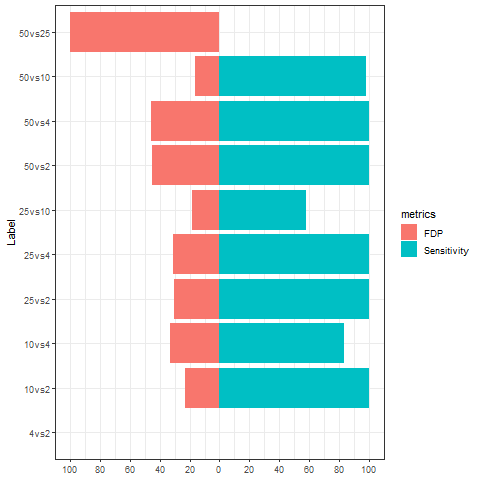

In [38]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
conditions = c("50vs25", "50vs10", "50vs4","50vs2","25vs10", "25vs4", "25vs2","10vs4", 
                          "10vs2", "4vs2")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)